In [1]:
import numpy as np
from PIL import ImageGrab
from PIL import Image
import cv2
import io
import time
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
game_url = "game/dino.html"
chrome_driver_path = "../chromedriver.exe"
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.set_window_size(200, 300)
        self._driver.get(os.path.abspath(game_url))
        if custom_config:
            self._driver.execute_script("Runner.config.ACCELERATION=0")
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        return self._driver.execute_script("Runner.instance_.restart()")
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def press_down(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_DOWN)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array)
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

In [3]:
class DinoAgent:
    def __init__(self,game):
        self._game = game;
        self.jump();
        time.sleep(.5)
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [4]:
#processing image as required
def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
#     image = cv2.Canny(image, threshold1 = 100, threshold2 = 200)
#     image = image[10:140,0:200] #img[y:y+h, x:x+w]
#     image = resized_image = cv2.resize(image, (80, 80)) 
    image = cv2.resize(image, (0,0), fx = 0.15, fy = 0.10)
    image = image[2:38,10:50] #img[y:y+h, x:x+w]
    image = cv2.Canny(image, threshold1 = 200, threshold2 = 200)
    return  image

In [5]:
def grab_screen(_driver = None):
    screen =  np.array(ImageGrab.grab(bbox=(0,180,400,400)))
    image = process_img(screen)
    if _driver!=None:
        image = _driver.get_screenshot_as_png()
    return image

In [6]:
# print(grab_screen().shape)
# game = Game()
# dino = DinoAgent(game)
# last_time = time.time()
# while(True):
    
# # #     print('loop took {} seconds'.format(time.time()-last_time))
# # #     last_time = time.time()
# # #     cv2.imwrite("./img_data/dino"+str(time())+".jpg",image)
# # #     dino.duck()
# #     #exit on q pres
# # #     print('{0} {1} '.format(r_t,end_t))
# # #     cv2.imshow('window',game.grab_screen())
    
#     image = grab_screen()
#     cv2.imshow('window',image)
#     print(image.shape[0])
# #     cv2.destroyAllWindows()

# # #     from matplotlib import pyplot as plt
# # #     plt.imshow(image)
# # #     plt.title('my picture')
# # #     plt.show()

# # #     grab_screen()
# #     if(dino.is_crashed()):
# #         #jumping starts the game again if dino has crashed
# # #         temp = (game.get_score())
# #         game.restart()
#     if (cv2.waitKey(25) & 0xFF == ord('q')):
#         cv2.destroyAllWindows()
#         game.end()
# #         cv2.imwrite('dino.jpg',image)
#         break

In [7]:
import pickle
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.5 # decay rate of past observations original 0.99
OBSERVATION = 20000. # timesteps to observe before training
EXPLORE = 50000 #300000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 4
LEARNING_RATE = 1e-4

In [12]:
"""initial variable caching, done only once"""
# save_obj(FINAL_EPSILON,"epsilon")
# t = 0
# save_obj(t,"time")
# D = deque()
# save_obj(D,"D")

'initial variable caching, done only once'

In [13]:
img_rows , img_cols = 40,20
img_channels = 4 #We stack 4 frames

In [14]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Convolution2D(32, 8, 8, subsample=(4, 4), border_mode='same',input_shape=(img_cols,img_rows,img_channels)))  #80*80*4
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [15]:
def trainNetwork(model,game_state,observe=False):
    # open up a game state to communicate with emulator
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #deque()
    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 
    x_t, r_0, terminal = game_state.get_state(do_nothing)
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4


    if observe :#args['mode'] == 'Run':
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon")#FINAL_EPSILON #INITIAL_EPSILON
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time")
    while (True):
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if  random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[action_index] = 1
        #We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE #update to original asap

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('loop took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability
                Q_sa = model.predict(state_t1)
                
                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    temp_q_max = np.max(Q_sa)
                    q_max_df.loc[len(q_max_df)] = temp_q_max
                    targets[i, action_t] = reward_t + GAMMA * temp_q_max
            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
        else:
            #artificial time delay as training done with this delay
            loss_df.loc[len(loss_df)] = 0
            time.sleep(0.15)
        s_t = s_t1
        t = t + 1
        
        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            
            model.save_weights("model.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv")
            scores_df.to_csv("./objects/scores_df.csv")
            actions_df.to_csv("./objects/actions_df.csv")
            show_plots(t=t);
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [16]:
loss_df = pd.read_csv("./objects/loss_df.csv")
scores_df = pd.read_csv("./objects/scores_df.csv")
actions_df = pd.read_csv("./objects/actions_df.csv")
q_max_df = pd.read_csv("./objects/q_values.csv")

In [17]:
def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)
    model = buildmodel()
    trainNetwork(model,game_state,observe=observe)

In [18]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img()
        self._display.__next__()
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1]
        reward = 0.1
        is_over = False
        if actions[1] == 1:
            self._agent.jump()

        image = grab_screen()
        self._display.send(image)

        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = self._game.get_score()
            self._game.restart()
            reward = -5
            is_over = True
        return image, reward, is_over

In [19]:
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
from keras.callbacks import TensorBoard
from collections import deque
import random
import json

In [20]:
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        # Create window with freedom of dimensions
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
#         cv2.imwrite("screenshot"+str(frame)+".png",screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

In [ ]:
playGame();

Now we build the model
We finish building the model


C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(20, 40, 4..., strides=(4, 4), padding="same")`
  after removing the cwd from sys.path.
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2), padding="same")`
  
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  


loop took 0.4553959369659424 seconds
TIMESTEP 1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21493911743164062 seconds
TIMESTEP 2 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18662071228027344 seconds
TIMESTEP 3 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18825078010559082 seconds
TIMESTEP 4 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190852165222168 seconds
TIMESTEP 5 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1860363483428955 seconds
TIMESTEP 6 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18720245361328125 seconds
TIMESTEP 7 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19925928115844727 seconds
TIMESTEP 8 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  

loop took 0.21760225296020508 seconds
TIMESTEP 66 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18741178512573242 seconds
TIMESTEP 67 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22390246391296387 seconds
TIMESTEP 68 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23078274726867676 seconds
TIMESTEP 69 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18742012977600098 seconds
TIMESTEP 70 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18634438514709473 seconds
TIMESTEP 71 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20293426513671875 seconds
TIMESTEP 72 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190992832183838 seconds
TIMESTEP 73 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1

TIMESTEP 130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1868453025817871 seconds
TIMESTEP 131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2118072509765625 seconds
TIMESTEP 132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20857524871826172 seconds
TIMESTEP 133 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20666050910949707 seconds
TIMESTEP 134 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1855626106262207 seconds
TIMESTEP 135 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18699049949645996 seconds
TIMESTEP 136 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2182157039642334 seconds
TIMESTEP 137 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0

TIMESTEP 194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24034404754638672 seconds
TIMESTEP 195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21324992179870605 seconds
TIMESTEP 196 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2484607696533203 seconds
TIMESTEP 197 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21924924850463867 seconds
TIMESTEP 198 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20361876487731934 seconds
TIMESTEP 199 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20437288284301758 seconds
TIMESTEP 200 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23375654220581055 seconds
TIMESTEP 201 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop too

loop took 0.21914029121398926 seconds
TIMESTEP 258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18679141998291016 seconds
TIMESTEP 259 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2059464454650879 seconds
TIMESTEP 260 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.218109130859375 seconds
TIMESTEP 261 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1857614517211914 seconds
TIMESTEP 262 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21764039993286133 seconds
TIMESTEP 263 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22898578643798828 seconds
TIMESTEP 264 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23899531364440918 seconds
TIMESTEP 265 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWAR

loop took 0.21761512756347656 seconds
TIMESTEP 322 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2034311294555664 seconds
TIMESTEP 323 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22757887840270996 seconds
TIMESTEP 324 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24106645584106445 seconds
TIMESTEP 325 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20357418060302734 seconds
TIMESTEP 326 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21755218505859375 seconds
TIMESTEP 327 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20313811302185059 seconds
TIMESTEP 328 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23253679275512695 seconds
TIMESTEP 329 / STATE observe / EPSILON 0.0001 / ACTION 1 / RE

TIMESTEP 386 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21863532066345215 seconds
TIMESTEP 387 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24222993850708008 seconds
TIMESTEP 388 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24207830429077148 seconds
TIMESTEP 389 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2029893398284912 seconds
TIMESTEP 390 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20377516746520996 seconds
TIMESTEP 391 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21857929229736328 seconds
TIMESTEP 392 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2165393829345703 seconds
TIMESTEP 393 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took

loop took 0.20436930656433105 seconds
TIMESTEP 451 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.27321648597717285 seconds
TIMESTEP 452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22729063034057617 seconds
TIMESTEP 453 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033543586730957 seconds
TIMESTEP 454 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190096378326416 seconds
TIMESTEP 455 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21746158599853516 seconds
TIMESTEP 456 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23230504989624023 seconds
TIMESTEP 457 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20626020431518555 seconds
TIMESTEP 458 / STATE observe / EPSILON 0.0001 / ACTION 0 / REW

TIMESTEP 515 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2295219898223877 seconds
TIMESTEP 516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20908594131469727 seconds
TIMESTEP 517 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21999335289001465 seconds
TIMESTEP 518 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20116496086120605 seconds
TIMESTEP 519 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20461702346801758 seconds
TIMESTEP 520 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23411273956298828 seconds
TIMESTEP 521 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18787837028503418 seconds
TIMESTEP 522 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop too

TIMESTEP 579 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21788763999938965 seconds
TIMESTEP 580 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23651528358459473 seconds
TIMESTEP 581 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20338129997253418 seconds
TIMESTEP 582 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20363497734069824 seconds
TIMESTEP 583 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22387266159057617 seconds
TIMESTEP 584 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2105245590209961 seconds
TIMESTEP 585 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2058405876159668 seconds
TIMESTEP 586 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took

TIMESTEP 643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24102163314819336 seconds
TIMESTEP 644 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22538208961486816 seconds
TIMESTEP 645 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18889784812927246 seconds
TIMESTEP 646 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20346546173095703 seconds
TIMESTEP 647 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20209264755249023 seconds
TIMESTEP 648 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2201557159423828 seconds
TIMESTEP 649 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18688106536865234 seconds
TIMESTEP 650 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop too

loop took 0.20263004302978516 seconds
TIMESTEP 707 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23326444625854492 seconds
TIMESTEP 708 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23685765266418457 seconds
TIMESTEP 709 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21747732162475586 seconds
TIMESTEP 710 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189638614654541 seconds
TIMESTEP 711 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2038555145263672 seconds
TIMESTEP 712 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2332630157470703 seconds
TIMESTEP 713 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187199592590332 seconds
TIMESTEP 714 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWAR

loop took 0.2032489776611328 seconds
TIMESTEP 771 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21988964080810547 seconds
TIMESTEP 772 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23407816886901855 seconds
TIMESTEP 773 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21724772453308105 seconds
TIMESTEP 774 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2043139934539795 seconds
TIMESTEP 775 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24232006072998047 seconds
TIMESTEP 776 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22557425498962402 seconds
TIMESTEP 777 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196059226989746 seconds
TIMESTEP 778 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWA

loop took 0.21947908401489258 seconds
TIMESTEP 835 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2586326599121094 seconds
TIMESTEP 836 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2245800495147705 seconds
TIMESTEP 837 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21822524070739746 seconds
TIMESTEP 838 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21784639358520508 seconds
TIMESTEP 839 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2053542137145996 seconds
TIMESTEP 840 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22053241729736328 seconds
TIMESTEP 841 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23328328132629395 seconds
TIMESTEP 842 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWA

TIMESTEP 898 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22421932220458984 seconds
TIMESTEP 899 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21187758445739746 seconds
TIMESTEP 900 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23199176788330078 seconds
TIMESTEP 901 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22014498710632324 seconds
TIMESTEP 902 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2329716682434082 seconds
TIMESTEP 903 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2186110019683838 seconds
TIMESTEP 904 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24965691566467285 seconds
TIMESTEP 905 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took

loop took 0.21975922584533691 seconds
TIMESTEP 962 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2034440040588379 seconds
TIMESTEP 963 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20956134796142578 seconds
TIMESTEP 964 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21213698387145996 seconds
TIMESTEP 965 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2029857635498047 seconds
TIMESTEP 966 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21773386001586914 seconds
TIMESTEP 967 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21843814849853516 seconds
TIMESTEP 968 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2498617172241211 seconds
TIMESTEP 969 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWA

C:\Users\ravi7\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


TIMESTEP 1000 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.4543023109436035 seconds
TIMESTEP 1001 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18628740310668945 seconds
TIMESTEP 1002 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21853232383728027 seconds
TIMESTEP 1003 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189650535583496 seconds
TIMESTEP 1004 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20422792434692383 seconds
TIMESTEP 1005 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23508119583129883 seconds
TIMESTEP 1006 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23356962203979492 seconds
TIMESTEP 1007 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.22603535652160645 seconds
TIMESTEP 1065 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20523500442504883 seconds
TIMESTEP 1066 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20322012901306152 seconds
TIMESTEP 1067 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2016160488128662 seconds
TIMESTEP 1068 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23342442512512207 seconds
TIMESTEP 1069 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21962451934814453 seconds
TIMESTEP 1070 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20224738121032715 seconds
TIMESTEP 1071 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22543001174926758 seconds
TIMESTEP 1072 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.22374296188354492 seconds
TIMESTEP 1129 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20403218269348145 seconds
TIMESTEP 1130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20402288436889648 seconds
TIMESTEP 1131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23155665397644043 seconds
TIMESTEP 1132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.252535343170166 seconds
TIMESTEP 1133 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2035694122314453 seconds
TIMESTEP 1134 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22088932991027832 seconds
TIMESTEP 1135 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23848414421081543 seconds
TIMESTEP 1136 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.21164321899414062 seconds
TIMESTEP 1193 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18993401527404785 seconds
TIMESTEP 1194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1859755516052246 seconds
TIMESTEP 1195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18744397163391113 seconds
TIMESTEP 1196 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22017765045166016 seconds
TIMESTEP 1197 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20427227020263672 seconds
TIMESTEP 1198 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18441319465637207 seconds
TIMESTEP 1199 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22811245918273926 seconds
TIMESTEP 1200 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.22397780418395996 seconds
TIMESTEP 1257 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.219620943069458 seconds
TIMESTEP 1258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20491385459899902 seconds
TIMESTEP 1259 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.186082124710083 seconds
TIMESTEP 1260 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21891236305236816 seconds
TIMESTEP 1261 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20192384719848633 seconds
TIMESTEP 1262 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20301342010498047 seconds
TIMESTEP 1263 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22391986846923828 seconds
TIMESTEP 1264 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2496318817138672 seconds
TIMESTEP 1321 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2344801425933838 seconds
TIMESTEP 1322 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24978947639465332 seconds
TIMESTEP 1323 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25124073028564453 seconds
TIMESTEP 1324 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2737090587615967 seconds
TIMESTEP 1325 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24152517318725586 seconds
TIMESTEP 1326 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26104283332824707 seconds
TIMESTEP 1327 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23895835876464844 seconds
TIMESTEP 1328 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.20206499099731445 seconds
TIMESTEP 1385 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18699312210083008 seconds
TIMESTEP 1386 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18691325187683105 seconds
TIMESTEP 1387 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22848963737487793 seconds
TIMESTEP 1388 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20863103866577148 seconds
TIMESTEP 1389 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20697879791259766 seconds
TIMESTEP 1390 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18339896202087402 seconds
TIMESTEP 1391 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1882326602935791 seconds
TIMESTEP 1392 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2260119915008545 seconds
TIMESTEP 1449 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2062549591064453 seconds
TIMESTEP 1450 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2166430950164795 seconds
TIMESTEP 1451 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21773242950439453 seconds
TIMESTEP 1452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23340845108032227 seconds
TIMESTEP 1453 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2215135097503662 seconds
TIMESTEP 1454 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21894192695617676 seconds
TIMESTEP 1455 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24205589294433594 seconds
TIMESTEP 1456 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.23598790168762207 seconds
TIMESTEP 1513 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20427966117858887 seconds
TIMESTEP 1514 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20661306381225586 seconds
TIMESTEP 1515 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22969317436218262 seconds
TIMESTEP 1516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23434090614318848 seconds
TIMESTEP 1517 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23661303520202637 seconds
TIMESTEP 1518 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24776959419250488 seconds
TIMESTEP 1519 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26117444038391113 seconds
TIMESTEP 1520 / STATE observe / EPSILON 0.0001 / ACT

loop took 0.2648022174835205 seconds
TIMESTEP 1577 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23357057571411133 seconds
TIMESTEP 1578 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23317384719848633 seconds
TIMESTEP 1579 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23442530632019043 seconds
TIMESTEP 1580 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23557376861572266 seconds
TIMESTEP 1581 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23433947563171387 seconds
TIMESTEP 1582 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2424325942993164 seconds
TIMESTEP 1583 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.1924891471862793 seconds
TIMESTEP 1584 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2049250602722168 seconds
TIMESTEP 1641 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20223212242126465 seconds
TIMESTEP 1642 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20474839210510254 seconds
TIMESTEP 1643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2088303565979004 seconds
TIMESTEP 1644 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2110767364501953 seconds
TIMESTEP 1645 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18808221817016602 seconds
TIMESTEP 1646 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18827462196350098 seconds
TIMESTEP 1647 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20473337173461914 seconds
TIMESTEP 1648 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2340991497039795 seconds
TIMESTEP 1705 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21902775764465332 seconds
TIMESTEP 1706 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22050213813781738 seconds
TIMESTEP 1707 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2173314094543457 seconds
TIMESTEP 1708 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25081920623779297 seconds
TIMESTEP 1709 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21677637100219727 seconds
TIMESTEP 1710 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2162306308746338 seconds
TIMESTEP 1711 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2080092430114746 seconds
TIMESTEP 1712 / STATE observe / EPSILON 0.0001 / ACTION 0

loop took 0.24860095977783203 seconds
TIMESTEP 1769 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24978327751159668 seconds
TIMESTEP 1770 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23331594467163086 seconds
TIMESTEP 1771 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23772335052490234 seconds
TIMESTEP 1772 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2688579559326172 seconds
TIMESTEP 1773 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2582414150238037 seconds
TIMESTEP 1774 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23587512969970703 seconds
TIMESTEP 1775 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26395654678344727 seconds
TIMESTEP 1776 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.2181684970855713 seconds
TIMESTEP 1833 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21925711631774902 seconds
TIMESTEP 1834 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21756863594055176 seconds
TIMESTEP 1835 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22800445556640625 seconds
TIMESTEP 1836 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24413466453552246 seconds
TIMESTEP 1837 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23097896575927734 seconds
TIMESTEP 1838 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20551419258117676 seconds
TIMESTEP 1839 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20114922523498535 seconds
TIMESTEP 1840 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.235947847366333 seconds
TIMESTEP 1897 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23551058769226074 seconds
TIMESTEP 1898 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.228651762008667 seconds
TIMESTEP 1899 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22574615478515625 seconds
TIMESTEP 1900 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2632923126220703 seconds
TIMESTEP 1901 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2341620922088623 seconds
TIMESTEP 1902 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2488844394683838 seconds
TIMESTEP 1903 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23535537719726562 seconds
TIMESTEP 1904 / STATE observe / EPSILON 0.0001 / ACTION 0 / 

loop took 0.24284887313842773 seconds
TIMESTEP 1961 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21928882598876953 seconds
TIMESTEP 1962 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23174571990966797 seconds
TIMESTEP 1963 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2204761505126953 seconds
TIMESTEP 1964 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21773266792297363 seconds
TIMESTEP 1965 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21897220611572266 seconds
TIMESTEP 1966 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18740582466125488 seconds
TIMESTEP 1967 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22600817680358887 seconds
TIMESTEP 1968 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.23518919944763184 seconds
TIMESTEP 2025 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20238494873046875 seconds
TIMESTEP 2026 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20506501197814941 seconds
TIMESTEP 2027 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22351288795471191 seconds
TIMESTEP 2028 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2283027172088623 seconds
TIMESTEP 2029 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21816372871398926 seconds
TIMESTEP 2030 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21953487396240234 seconds
TIMESTEP 2031 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2034611701965332 seconds
TIMESTEP 2032 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 2088 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22977733612060547 seconds
TIMESTEP 2089 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21779251098632812 seconds
TIMESTEP 2090 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187662124633789 seconds
TIMESTEP 2091 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2324833869934082 seconds
TIMESTEP 2092 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23445940017700195 seconds
TIMESTEP 2093 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21900177001953125 seconds
TIMESTEP 2094 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21089816093444824 seconds
TIMESTEP 2095 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.22630929946899414 seconds
TIMESTEP 2153 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21750426292419434 seconds
TIMESTEP 2154 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21697235107421875 seconds
TIMESTEP 2155 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21941304206848145 seconds
TIMESTEP 2156 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21739721298217773 seconds
TIMESTEP 2157 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20479130744934082 seconds
TIMESTEP 2158 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21987581253051758 seconds
TIMESTEP 2159 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25701022148132324 seconds
TIMESTEP 2160 / STATE observe / EPSILON 0.0001 / ACT

loop took 0.22626686096191406 seconds
TIMESTEP 2217 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21868157386779785 seconds
TIMESTEP 2218 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20367908477783203 seconds
TIMESTEP 2219 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2034924030303955 seconds
TIMESTEP 2220 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.218658447265625 seconds
TIMESTEP 2221 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21763825416564941 seconds
TIMESTEP 2222 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21679377555847168 seconds
TIMESTEP 2223 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26050806045532227 seconds
TIMESTEP 2224 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 2280 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21747565269470215 seconds
TIMESTEP 2281 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2039167881011963 seconds
TIMESTEP 2282 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.236525297164917 seconds
TIMESTEP 2283 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2586171627044678 seconds
TIMESTEP 2284 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2544221878051758 seconds
TIMESTEP 2285 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2205655574798584 seconds
TIMESTEP 2286 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2049393653869629 seconds
TIMESTEP 2287 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop t

loop took 0.21825671195983887 seconds
TIMESTEP 2344 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21795296669006348 seconds
TIMESTEP 2345 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20395565032958984 seconds
TIMESTEP 2346 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2027909755706787 seconds
TIMESTEP 2347 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20566844940185547 seconds
TIMESTEP 2348 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24748468399047852 seconds
TIMESTEP 2349 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2051999568939209 seconds
TIMESTEP 2350 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21701717376708984 seconds
TIMESTEP 2351 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 2407 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18604373931884766 seconds
TIMESTEP 2408 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21821093559265137 seconds
TIMESTEP 2409 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21805620193481445 seconds
TIMESTEP 2410 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20476889610290527 seconds
TIMESTEP 2411 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18862652778625488 seconds
TIMESTEP 2412 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23379111289978027 seconds
TIMESTEP 2413 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20217680931091309 seconds
TIMESTEP 2414 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  

TIMESTEP 2471 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2487790584564209 seconds
TIMESTEP 2472 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25190162658691406 seconds
TIMESTEP 2473 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23302626609802246 seconds
TIMESTEP 2474 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23343300819396973 seconds
TIMESTEP 2475 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24460101127624512 seconds
TIMESTEP 2476 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24202227592468262 seconds
TIMESTEP 2477 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23257231712341309 seconds
TIMESTEP 2478 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.22006916999816895 seconds
TIMESTEP 2535 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24120593070983887 seconds
TIMESTEP 2536 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24092793464660645 seconds
TIMESTEP 2537 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21859025955200195 seconds
TIMESTEP 2538 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2188854217529297 seconds
TIMESTEP 2539 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23363256454467773 seconds
TIMESTEP 2540 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.249403715133667 seconds
TIMESTEP 2541 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20354509353637695 seconds
TIMESTEP 2542 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 2598 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2323462963104248 seconds
TIMESTEP 2599 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2353043556213379 seconds
TIMESTEP 2600 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2487804889678955 seconds
TIMESTEP 2601 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23569607734680176 seconds
TIMESTEP 2602 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2487635612487793 seconds
TIMESTEP 2603 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24619317054748535 seconds
TIMESTEP 2604 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23742222785949707 seconds
TIMESTEP 2605 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loo

loop took 0.20409321784973145 seconds
TIMESTEP 2662 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18719816207885742 seconds
TIMESTEP 2663 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2014462947845459 seconds
TIMESTEP 2664 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21885013580322266 seconds
TIMESTEP 2665 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21812057495117188 seconds
TIMESTEP 2666 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20550203323364258 seconds
TIMESTEP 2667 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22111225128173828 seconds
TIMESTEP 2668 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2313849925994873 seconds
TIMESTEP 2669 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 2725 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21902084350585938 seconds
TIMESTEP 2726 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21755504608154297 seconds
TIMESTEP 2727 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22629380226135254 seconds
TIMESTEP 2728 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22802519798278809 seconds
TIMESTEP 2729 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2028970718383789 seconds
TIMESTEP 2730 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22017550468444824 seconds
TIMESTEP 2731 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20110726356506348 seconds
TIMESTEP 2732 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


TIMESTEP 2789 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21760320663452148 seconds
TIMESTEP 2790 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2349402904510498 seconds
TIMESTEP 2791 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24522137641906738 seconds
TIMESTEP 2792 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24100255966186523 seconds
TIMESTEP 2793 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20337605476379395 seconds
TIMESTEP 2794 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21596765518188477 seconds
TIMESTEP 2795 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21889185905456543 seconds
TIMESTEP 2796 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.2338566780090332 seconds
TIMESTEP 2853 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.219620943069458 seconds
TIMESTEP 2854 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24191856384277344 seconds
TIMESTEP 2855 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24196314811706543 seconds
TIMESTEP 2856 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26374268531799316 seconds
TIMESTEP 2857 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.235551118850708 seconds
TIMESTEP 2858 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23522162437438965 seconds
TIMESTEP 2859 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26380062103271484 seconds
TIMESTEP 2860 / STATE observe / EPSILON 0.0001 / ACTION 0 

loop took 0.23335051536560059 seconds
TIMESTEP 2917 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21912455558776855 seconds
TIMESTEP 2918 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21888160705566406 seconds
TIMESTEP 2919 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22706890106201172 seconds
TIMESTEP 2920 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24459218978881836 seconds
TIMESTEP 2921 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21792101860046387 seconds
TIMESTEP 2922 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1852719783782959 seconds
TIMESTEP 2923 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2352440357208252 seconds
TIMESTEP 2924 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.26491737365722656 seconds
TIMESTEP 2981 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25266551971435547 seconds
TIMESTEP 2982 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2576727867126465 seconds
TIMESTEP 2983 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.256638765335083 seconds
TIMESTEP 2984 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.27777743339538574 seconds
TIMESTEP 2985 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25362277030944824 seconds
TIMESTEP 2986 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24819111824035645 seconds
TIMESTEP 2987 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.251528263092041 seconds
TIMESTEP 2988 / STATE observe / EPSILON 0.0001 / ACTION 0 

TIMESTEP 3044 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171797752380371 seconds
TIMESTEP 3045 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20399093627929688 seconds
TIMESTEP 3046 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20521998405456543 seconds
TIMESTEP 3047 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22481703758239746 seconds
TIMESTEP 3048 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20993423461914062 seconds
TIMESTEP 3049 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20448803901672363 seconds
TIMESTEP 3050 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21660900115966797 seconds
TIMESTEP 3051 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.2193295955657959 seconds
TIMESTEP 3108 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24834394454956055 seconds
TIMESTEP 3109 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1900618076324463 seconds
TIMESTEP 3110 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20235061645507812 seconds
TIMESTEP 3111 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21805882453918457 seconds
TIMESTEP 3112 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23430418968200684 seconds
TIMESTEP 3113 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21882343292236328 seconds
TIMESTEP 3114 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23289799690246582 seconds
TIMESTEP 3115 / STATE observe / EPSILON 0.0001 / ACTIO

TIMESTEP 3171 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2483808994293213 seconds
TIMESTEP 3172 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.28252291679382324 seconds
TIMESTEP 3173 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2488842010498047 seconds
TIMESTEP 3174 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24901843070983887 seconds
TIMESTEP 3175 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190852165222168 seconds
TIMESTEP 3176 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24803900718688965 seconds
TIMESTEP 3177 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2542152404785156 seconds
TIMESTEP 3178 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
lo

TIMESTEP 3235 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24999117851257324 seconds
TIMESTEP 3236 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23363590240478516 seconds
TIMESTEP 3237 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23354578018188477 seconds
TIMESTEP 3238 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22018790245056152 seconds
TIMESTEP 3239 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21709465980529785 seconds
TIMESTEP 3240 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23193717002868652 seconds
TIMESTEP 3241 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21961236000061035 seconds
TIMESTEP 3242 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0

TIMESTEP 3299 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20525240898132324 seconds
TIMESTEP 3300 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23205900192260742 seconds
TIMESTEP 3301 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22072672843933105 seconds
TIMESTEP 3302 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23408031463623047 seconds
TIMESTEP 3303 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23350262641906738 seconds
TIMESTEP 3304 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2501091957092285 seconds
TIMESTEP 3305 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2398989200592041 seconds
TIMESTEP 3306 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.21843934059143066 seconds
TIMESTEP 3363 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335832118988037 seconds
TIMESTEP 3364 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23393630981445312 seconds
TIMESTEP 3365 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23425078392028809 seconds
TIMESTEP 3366 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22804713249206543 seconds
TIMESTEP 3367 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22414231300354004 seconds
TIMESTEP 3368 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23566722869873047 seconds
TIMESTEP 3369 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20424294471740723 seconds
TIMESTEP 3370 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.21846675872802734 seconds
TIMESTEP 3427 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20533132553100586 seconds
TIMESTEP 3428 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2499544620513916 seconds
TIMESTEP 3429 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.200836181640625 seconds
TIMESTEP 3430 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18637847900390625 seconds
TIMESTEP 3431 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21226954460144043 seconds
TIMESTEP 3432 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2246260643005371 seconds
TIMESTEP 3433 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2054762840270996 seconds
TIMESTEP 3434 / STATE observe / EPSILON 0.0001 / ACTION 0 

TIMESTEP 3490 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24981689453125 seconds
TIMESTEP 3491 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.253049373626709 seconds
TIMESTEP 3492 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2445993423461914 seconds
TIMESTEP 3493 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24197936058044434 seconds
TIMESTEP 3494 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24433207511901855 seconds
TIMESTEP 3495 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25217580795288086 seconds
TIMESTEP 3496 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2614741325378418 seconds
TIMESTEP 3497 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop t

loop took 0.2209179401397705 seconds
TIMESTEP 3554 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20431303977966309 seconds
TIMESTEP 3555 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21934819221496582 seconds
TIMESTEP 3556 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23172831535339355 seconds
TIMESTEP 3557 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21866893768310547 seconds
TIMESTEP 3558 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2174999713897705 seconds
TIMESTEP 3559 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21869397163391113 seconds
TIMESTEP 3560 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2647528648376465 seconds
TIMESTEP 3561 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 3617 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21921157836914062 seconds
TIMESTEP 3618 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2062511444091797 seconds
TIMESTEP 3619 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20061302185058594 seconds
TIMESTEP 3620 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2180156707763672 seconds
TIMESTEP 3621 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20339131355285645 seconds
TIMESTEP 3622 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21727943420410156 seconds
TIMESTEP 3623 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2429640293121338 seconds
TIMESTEP 3624 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
lo

loop took 0.2351212501525879 seconds
TIMESTEP 3681 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23447608947753906 seconds
TIMESTEP 3682 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21840214729309082 seconds
TIMESTEP 3683 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21859335899353027 seconds
TIMESTEP 3684 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23347997665405273 seconds
TIMESTEP 3685 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22027134895324707 seconds
TIMESTEP 3686 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24388790130615234 seconds
TIMESTEP 3687 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22728371620178223 seconds
TIMESTEP 3688 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.24877381324768066 seconds
TIMESTEP 3745 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2356245517730713 seconds
TIMESTEP 3746 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21889996528625488 seconds
TIMESTEP 3747 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24451208114624023 seconds
TIMESTEP 3748 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22790217399597168 seconds
TIMESTEP 3749 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24564075469970703 seconds
TIMESTEP 3750 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2357935905456543 seconds
TIMESTEP 3751 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23224425315856934 seconds
TIMESTEP 3752 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 3808 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22460556030273438 seconds
TIMESTEP 3809 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22224092483520508 seconds
TIMESTEP 3810 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23280835151672363 seconds
TIMESTEP 3811 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23631930351257324 seconds
TIMESTEP 3812 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2640836238861084 seconds
TIMESTEP 3813 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2500731945037842 seconds
TIMESTEP 3814 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22025823593139648 seconds
TIMESTEP 3815 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.27905797958374023 seconds
TIMESTEP 3873 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23505473136901855 seconds
TIMESTEP 3874 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23485994338989258 seconds
TIMESTEP 3875 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26150083541870117 seconds
TIMESTEP 3876 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2680339813232422 seconds
TIMESTEP 3877 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2501709461212158 seconds
TIMESTEP 3878 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2345590591430664 seconds
TIMESTEP 3879 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2384195327758789 seconds
TIMESTEP 3880 / STATE observe / EPSILON 0.0001 / ACTION 0

TIMESTEP 3936 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23517346382141113 seconds
TIMESTEP 3937 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20181846618652344 seconds
TIMESTEP 3938 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20412039756774902 seconds
TIMESTEP 3939 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20711326599121094 seconds
TIMESTEP 3940 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22127056121826172 seconds
TIMESTEP 3941 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22756195068359375 seconds
TIMESTEP 3942 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21988654136657715 seconds
TIMESTEP 3943 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0

Now we save model
TIMESTEP 4000 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5766949653625488 seconds
TIMESTEP 4001 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20163393020629883 seconds
TIMESTEP 4002 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20333194732666016 seconds
TIMESTEP 4003 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21748685836791992 seconds
TIMESTEP 4004 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2329552173614502 seconds
TIMESTEP 4005 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23464012145996094 seconds
TIMESTEP 4006 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23571205139160156 seconds
TIMESTEP 4007 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_

TIMESTEP 4063 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.262160062789917 seconds
TIMESTEP 4064 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22416901588439941 seconds
TIMESTEP 4065 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335662841796875 seconds
TIMESTEP 4066 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24972915649414062 seconds
TIMESTEP 4067 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21886539459228516 seconds
TIMESTEP 4068 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2652242183685303 seconds
TIMESTEP 4069 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2348473072052002 seconds
TIMESTEP 4070 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop

loop took 0.21918129920959473 seconds
TIMESTEP 4127 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21755766868591309 seconds
TIMESTEP 4128 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2345566749572754 seconds
TIMESTEP 4129 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23532700538635254 seconds
TIMESTEP 4130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21930932998657227 seconds
TIMESTEP 4131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2247765064239502 seconds
TIMESTEP 4132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24273395538330078 seconds
TIMESTEP 4133 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20232772827148438 seconds
TIMESTEP 4134 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.20452070236206055 seconds
TIMESTEP 4191 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26351308822631836 seconds
TIMESTEP 4192 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2669532299041748 seconds
TIMESTEP 4193 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25170278549194336 seconds
TIMESTEP 4194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19989299774169922 seconds
TIMESTEP 4195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21892929077148438 seconds
TIMESTEP 4196 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23512887954711914 seconds
TIMESTEP 4197 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18710708618164062 seconds
TIMESTEP 4198 / STATE observe / EPSILON 0.0001 / ACTIO

TIMESTEP 4254 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2503657341003418 seconds
TIMESTEP 4255 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23299384117126465 seconds
TIMESTEP 4256 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26620984077453613 seconds
TIMESTEP 4257 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21834468841552734 seconds
TIMESTEP 4258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18727684020996094 seconds
TIMESTEP 4259 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22515368461608887 seconds
TIMESTEP 4260 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21182990074157715 seconds
TIMESTEP 4261 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.2058098316192627 seconds
TIMESTEP 4318 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21923446655273438 seconds
TIMESTEP 4319 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2568049430847168 seconds
TIMESTEP 4320 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2241377830505371 seconds
TIMESTEP 4321 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23377275466918945 seconds
TIMESTEP 4322 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23576045036315918 seconds
TIMESTEP 4323 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2344658374786377 seconds
TIMESTEP 4324 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24967265129089355 seconds
TIMESTEP 4325 / STATE observe / EPSILON 0.0001 / ACTION 1

loop took 0.20712971687316895 seconds
TIMESTEP 4382 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20038437843322754 seconds
TIMESTEP 4383 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20178723335266113 seconds
TIMESTEP 4384 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23380351066589355 seconds
TIMESTEP 4385 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2046515941619873 seconds
TIMESTEP 4386 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2339019775390625 seconds
TIMESTEP 4387 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2113635540008545 seconds
TIMESTEP 4388 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22532057762145996 seconds
TIMESTEP 4389 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.20373296737670898 seconds
TIMESTEP 4446 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21795225143432617 seconds
TIMESTEP 4447 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2307281494140625 seconds
TIMESTEP 4448 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23682761192321777 seconds
TIMESTEP 4449 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18981146812438965 seconds
TIMESTEP 4450 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20250678062438965 seconds
TIMESTEP 4451 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21682310104370117 seconds
TIMESTEP 4452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22353029251098633 seconds
TIMESTEP 4453 / STATE observe / EPSILON 0.0001 / ACTIO

TIMESTEP 4509 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23746514320373535 seconds
TIMESTEP 4510 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24802494049072266 seconds
TIMESTEP 4511 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23616576194763184 seconds
TIMESTEP 4512 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.273578405380249 seconds
TIMESTEP 4513 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2444145679473877 seconds
TIMESTEP 4514 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24547886848449707 seconds
TIMESTEP 4515 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2523646354675293 seconds
TIMESTEP 4516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loo

loop took 0.22664642333984375 seconds
TIMESTEP 4573 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21879935264587402 seconds
TIMESTEP 4574 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21822547912597656 seconds
TIMESTEP 4575 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22005701065063477 seconds
TIMESTEP 4576 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2500593662261963 seconds
TIMESTEP 4577 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23539280891418457 seconds
TIMESTEP 4578 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.260573148727417 seconds
TIMESTEP 4579 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23968219757080078 seconds
TIMESTEP 4580 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.24031949043273926 seconds
TIMESTEP 4637 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23418498039245605 seconds
TIMESTEP 4638 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2044661045074463 seconds
TIMESTEP 4639 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2022387981414795 seconds
TIMESTEP 4640 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2503073215484619 seconds
TIMESTEP 4641 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21791648864746094 seconds
TIMESTEP 4642 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22721481323242188 seconds
TIMESTEP 4643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22604751586914062 seconds
TIMESTEP 4644 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.24434375762939453 seconds
TIMESTEP 4701 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20287322998046875 seconds
TIMESTEP 4702 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189788818359375 seconds
TIMESTEP 4703 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2001957893371582 seconds
TIMESTEP 4704 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.252612829208374 seconds
TIMESTEP 4705 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20252275466918945 seconds
TIMESTEP 4706 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20493841171264648 seconds
TIMESTEP 4707 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22701549530029297 seconds
TIMESTEP 4708 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.24480056762695312 seconds
TIMESTEP 4765 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21720504760742188 seconds
TIMESTEP 4766 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185652256011963 seconds
TIMESTEP 4767 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21897244453430176 seconds
TIMESTEP 4768 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23239684104919434 seconds
TIMESTEP 4769 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23561620712280273 seconds
TIMESTEP 4770 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2339482307434082 seconds
TIMESTEP 4771 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22922229766845703 seconds
TIMESTEP 4772 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2654111385345459 seconds
TIMESTEP 4829 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2516610622406006 seconds
TIMESTEP 4830 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24883747100830078 seconds
TIMESTEP 4831 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24818801879882812 seconds
TIMESTEP 4832 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2634239196777344 seconds
TIMESTEP 4833 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23448967933654785 seconds
TIMESTEP 4834 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20530247688293457 seconds
TIMESTEP 4835 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23229002952575684 seconds
TIMESTEP 4836 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.23471498489379883 seconds
TIMESTEP 4893 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21840596199035645 seconds
TIMESTEP 4894 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21683311462402344 seconds
TIMESTEP 4895 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196793556213379 seconds
TIMESTEP 4896 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23386192321777344 seconds
TIMESTEP 4897 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23459720611572266 seconds
TIMESTEP 4898 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23439502716064453 seconds
TIMESTEP 4899 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.250518798828125 seconds
TIMESTEP 4900 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.21848511695861816 seconds
TIMESTEP 4957 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23365187644958496 seconds
TIMESTEP 4958 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22711753845214844 seconds
TIMESTEP 4959 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22800230979919434 seconds
TIMESTEP 4960 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2333674430847168 seconds
TIMESTEP 4961 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22008585929870605 seconds
TIMESTEP 4962 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23252558708190918 seconds
TIMESTEP 4963 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23514819145202637 seconds
TIMESTEP 4964 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2562284469604492 seconds
TIMESTEP 5021 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21738219261169434 seconds
TIMESTEP 5022 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2336876392364502 seconds
TIMESTEP 5023 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23380112648010254 seconds
TIMESTEP 5024 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23536968231201172 seconds
TIMESTEP 5025 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23273396492004395 seconds
TIMESTEP 5026 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23536896705627441 seconds
TIMESTEP 5027 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21759557723999023 seconds
TIMESTEP 5028 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2146296501159668 seconds
TIMESTEP 5085 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21748995780944824 seconds
TIMESTEP 5086 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21774649620056152 seconds
TIMESTEP 5087 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21892642974853516 seconds
TIMESTEP 5088 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23342514038085938 seconds
TIMESTEP 5089 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21954035758972168 seconds
TIMESTEP 5090 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23319530487060547 seconds
TIMESTEP 5091 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22780489921569824 seconds
TIMESTEP 5092 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.23242759704589844 seconds
TIMESTEP 5149 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20452642440795898 seconds
TIMESTEP 5150 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2199094295501709 seconds
TIMESTEP 5151 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22528815269470215 seconds
TIMESTEP 5152 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24048686027526855 seconds
TIMESTEP 5153 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20690202713012695 seconds
TIMESTEP 5154 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23325490951538086 seconds
TIMESTEP 5155 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21909523010253906 seconds
TIMESTEP 5156 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.26488637924194336 seconds
TIMESTEP 5213 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2336719036102295 seconds
TIMESTEP 5214 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22794175148010254 seconds
TIMESTEP 5215 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.19481420516967773 seconds
TIMESTEP 5216 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23373055458068848 seconds
TIMESTEP 5217 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1873483657836914 seconds
TIMESTEP 5218 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20270800590515137 seconds
TIMESTEP 5219 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23554301261901855 seconds
TIMESTEP 5220 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 5276 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2167656421661377 seconds
TIMESTEP 5277 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2030801773071289 seconds
TIMESTEP 5278 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22071266174316406 seconds
TIMESTEP 5279 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2237224578857422 seconds
TIMESTEP 5280 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2113189697265625 seconds
TIMESTEP 5281 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20365309715270996 seconds
TIMESTEP 5282 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21849584579467773 seconds
TIMESTEP 5283 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loo

loop took 0.2509145736694336 seconds
TIMESTEP 5341 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24971437454223633 seconds
TIMESTEP 5342 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21869921684265137 seconds
TIMESTEP 5343 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24961614608764648 seconds
TIMESTEP 5344 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.27349352836608887 seconds
TIMESTEP 5345 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21143317222595215 seconds
TIMESTEP 5346 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23447346687316895 seconds
TIMESTEP 5347 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24705767631530762 seconds
TIMESTEP 5348 / STATE observe / EPSILON 0.0001 / ACTI

TIMESTEP 5404 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2225360870361328 seconds
TIMESTEP 5405 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19775819778442383 seconds
TIMESTEP 5406 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22064661979675293 seconds
TIMESTEP 5407 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25669407844543457 seconds
TIMESTEP 5408 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24117374420166016 seconds
TIMESTEP 5409 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21902203559875488 seconds
TIMESTEP 5410 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2358229160308838 seconds
TIMESTEP 5411 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.24969935417175293 seconds
TIMESTEP 5469 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2331681251525879 seconds
TIMESTEP 5470 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23524928092956543 seconds
TIMESTEP 5471 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2483670711517334 seconds
TIMESTEP 5472 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26776838302612305 seconds
TIMESTEP 5473 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24861788749694824 seconds
TIMESTEP 5474 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23308801651000977 seconds
TIMESTEP 5475 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25054240226745605 seconds
TIMESTEP 5476 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2161703109741211 seconds
TIMESTEP 5533 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20511722564697266 seconds
TIMESTEP 5534 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1863384246826172 seconds
TIMESTEP 5535 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23056530952453613 seconds
TIMESTEP 5536 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2217411994934082 seconds
TIMESTEP 5537 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21927690505981445 seconds
TIMESTEP 5538 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20348095893859863 seconds
TIMESTEP 5539 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20273399353027344 seconds
TIMESTEP 5540 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 5596 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23414921760559082 seconds
TIMESTEP 5597 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1871631145477295 seconds
TIMESTEP 5598 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20248031616210938 seconds
TIMESTEP 5599 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21210932731628418 seconds
TIMESTEP 5600 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22666478157043457 seconds
TIMESTEP 5601 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854114532470703 seconds
TIMESTEP 5602 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22024154663085938 seconds
TIMESTEP 5603 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.22043538093566895 seconds
TIMESTEP 5660 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21788811683654785 seconds
TIMESTEP 5661 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20256471633911133 seconds
TIMESTEP 5662 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18654727935791016 seconds
TIMESTEP 5663 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21710944175720215 seconds
TIMESTEP 5664 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2329106330871582 seconds
TIMESTEP 5665 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2199411392211914 seconds
TIMESTEP 5666 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22111845016479492 seconds
TIMESTEP 5667 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.2179701328277588 seconds
TIMESTEP 5724 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23553800582885742 seconds
TIMESTEP 5725 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21876931190490723 seconds
TIMESTEP 5726 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21793103218078613 seconds
TIMESTEP 5727 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24446415901184082 seconds
TIMESTEP 5728 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.25464725494384766 seconds
TIMESTEP 5729 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20587563514709473 seconds
TIMESTEP 5730 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21681499481201172 seconds
TIMESTEP 5731 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.23676562309265137 seconds
TIMESTEP 5788 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2287311553955078 seconds
TIMESTEP 5789 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20621061325073242 seconds
TIMESTEP 5790 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20075726509094238 seconds
TIMESTEP 5791 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2205195426940918 seconds
TIMESTEP 5792 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23250579833984375 seconds
TIMESTEP 5793 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187974452972412 seconds
TIMESTEP 5794 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20402121543884277 seconds
TIMESTEP 5795 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 5851 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25894951820373535 seconds
TIMESTEP 5852 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23952245712280273 seconds
TIMESTEP 5853 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20487570762634277 seconds
TIMESTEP 5854 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20279288291931152 seconds
TIMESTEP 5855 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21684980392456055 seconds
TIMESTEP 5856 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2347860336303711 seconds
TIMESTEP 5857 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2039787769317627 seconds
TIMESTEP 5858 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.2163560390472412 seconds
TIMESTEP 5915 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189638614654541 seconds
TIMESTEP 5916 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23450922966003418 seconds
TIMESTEP 5917 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20377779006958008 seconds
TIMESTEP 5918 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22017836570739746 seconds
TIMESTEP 5919 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22841548919677734 seconds
TIMESTEP 5920 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23828387260437012 seconds
TIMESTEP 5921 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20363688468933105 seconds
TIMESTEP 5922 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.20336532592773438 seconds
TIMESTEP 5979 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2030332088470459 seconds
TIMESTEP 5980 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185990810394287 seconds
TIMESTEP 5981 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171318531036377 seconds
TIMESTEP 5982 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22011613845825195 seconds
TIMESTEP 5983 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22884202003479004 seconds
TIMESTEP 5984 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23839926719665527 seconds
TIMESTEP 5985 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20555472373962402 seconds
TIMESTEP 5986 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 6043 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2113344669342041 seconds
TIMESTEP 6044 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22513747215270996 seconds
TIMESTEP 6045 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21837210655212402 seconds
TIMESTEP 6046 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21959137916564941 seconds
TIMESTEP 6047 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20233154296875 seconds
TIMESTEP 6048 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21955537796020508 seconds
TIMESTEP 6049 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18677210807800293 seconds
TIMESTEP 6050 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loo

TIMESTEP 6107 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22968077659606934 seconds
TIMESTEP 6108 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22153162956237793 seconds
TIMESTEP 6109 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2040863037109375 seconds
TIMESTEP 6110 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20339155197143555 seconds
TIMESTEP 6111 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21680188179016113 seconds
TIMESTEP 6112 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23299551010131836 seconds
TIMESTEP 6113 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21930384635925293 seconds
TIMESTEP 6114 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.20430254936218262 seconds
TIMESTEP 6172 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2333385944366455 seconds
TIMESTEP 6173 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21929669380187988 seconds
TIMESTEP 6174 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21823596954345703 seconds
TIMESTEP 6175 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2582995891571045 seconds
TIMESTEP 6176 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2713942527770996 seconds
TIMESTEP 6177 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22156214714050293 seconds
TIMESTEP 6178 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21660757064819336 seconds
TIMESTEP 6179 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 6235 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18593764305114746 seconds
TIMESTEP 6236 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23477482795715332 seconds
TIMESTEP 6237 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23370003700256348 seconds
TIMESTEP 6238 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24279260635375977 seconds
TIMESTEP 6239 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24212408065795898 seconds
TIMESTEP 6240 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2536280155181885 seconds
TIMESTEP 6241 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21512651443481445 seconds
TIMESTEP 6242 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


TIMESTEP 6299 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20236563682556152 seconds
TIMESTEP 6300 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23403406143188477 seconds
TIMESTEP 6301 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21999430656433105 seconds
TIMESTEP 6302 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23430204391479492 seconds
TIMESTEP 6303 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22465968132019043 seconds
TIMESTEP 6304 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22786784172058105 seconds
TIMESTEP 6305 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20324301719665527 seconds
TIMESTEP 6306 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0

loop took 0.21842551231384277 seconds
TIMESTEP 6363 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20387721061706543 seconds
TIMESTEP 6364 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23256564140319824 seconds
TIMESTEP 6365 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22024178504943848 seconds
TIMESTEP 6366 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.203627347946167 seconds
TIMESTEP 6367 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23008036613464355 seconds
TIMESTEP 6368 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2208418846130371 seconds
TIMESTEP 6369 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21927356719970703 seconds
TIMESTEP 6370 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 6426 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2007007598876953 seconds
TIMESTEP 6427 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22681856155395508 seconds
TIMESTEP 6428 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24236321449279785 seconds
TIMESTEP 6429 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2194528579711914 seconds
TIMESTEP 6430 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21990752220153809 seconds
TIMESTEP 6431 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21772193908691406 seconds
TIMESTEP 6432 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23287200927734375 seconds
TIMESTEP 6433 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

TIMESTEP 6490 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2037525177001953 seconds
TIMESTEP 6491 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21843504905700684 seconds
TIMESTEP 6492 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25019145011901855 seconds
TIMESTEP 6493 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20449233055114746 seconds
TIMESTEP 6494 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21907830238342285 seconds
TIMESTEP 6495 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21192479133605957 seconds
TIMESTEP 6496 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2235429286956787 seconds
TIMESTEP 6497 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.20687222480773926 seconds
TIMESTEP 6554 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2013866901397705 seconds
TIMESTEP 6555 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25864720344543457 seconds
TIMESTEP 6556 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2412421703338623 seconds
TIMESTEP 6557 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21653294563293457 seconds
TIMESTEP 6558 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21944546699523926 seconds
TIMESTEP 6559 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21892428398132324 seconds
TIMESTEP 6560 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2343740463256836 seconds
TIMESTEP 6561 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 6617 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2170248031616211 seconds
TIMESTEP 6618 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21848678588867188 seconds
TIMESTEP 6619 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20534753799438477 seconds
TIMESTEP 6620 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24925518035888672 seconds
TIMESTEP 6621 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21801161766052246 seconds
TIMESTEP 6622 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22018170356750488 seconds
TIMESTEP 6623 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2158656120300293 seconds
TIMESTEP 6624 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
l

loop took 0.24100399017333984 seconds
TIMESTEP 6681 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20253920555114746 seconds
TIMESTEP 6682 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1867201328277588 seconds
TIMESTEP 6683 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18549251556396484 seconds
TIMESTEP 6684 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22050786018371582 seconds
TIMESTEP 6685 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20354151725769043 seconds
TIMESTEP 6686 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18638181686401367 seconds
TIMESTEP 6687 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23431110382080078 seconds
TIMESTEP 6688 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.23772048950195312 seconds
TIMESTEP 6745 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2068028450012207 seconds
TIMESTEP 6746 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20089435577392578 seconds
TIMESTEP 6747 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21734333038330078 seconds
TIMESTEP 6748 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2337934970855713 seconds
TIMESTEP 6749 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176527976989746 seconds
TIMESTEP 6750 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21902823448181152 seconds
TIMESTEP 6751 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22809553146362305 seconds
TIMESTEP 6752 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.2255558967590332 seconds
TIMESTEP 6809 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191781997680664 seconds
TIMESTEP 6810 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20459699630737305 seconds
TIMESTEP 6811 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20395350456237793 seconds
TIMESTEP 6812 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21655774116516113 seconds
TIMESTEP 6813 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20349979400634766 seconds
TIMESTEP 6814 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21974444389343262 seconds
TIMESTEP 6815 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20761823654174805 seconds
TIMESTEP 6816 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.23318934440612793 seconds
TIMESTEP 6873 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20386171340942383 seconds
TIMESTEP 6874 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23285651206970215 seconds
TIMESTEP 6875 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23704242706298828 seconds
TIMESTEP 6876 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23123836517333984 seconds
TIMESTEP 6877 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21908998489379883 seconds
TIMESTEP 6878 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21857881546020508 seconds
TIMESTEP 6879 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21780872344970703 seconds
TIMESTEP 6880 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.23666143417358398 seconds
TIMESTEP 6937 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20490717887878418 seconds
TIMESTEP 6938 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2048814296722412 seconds
TIMESTEP 6939 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2174975872039795 seconds
TIMESTEP 6940 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23201632499694824 seconds
TIMESTEP 6941 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2203538417816162 seconds
TIMESTEP 6942 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21675872802734375 seconds
TIMESTEP 6943 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24681448936462402 seconds
TIMESTEP 6944 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 7000 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6238577365875244 seconds
TIMESTEP 7001 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20522451400756836 seconds
TIMESTEP 7002 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2169792652130127 seconds
TIMESTEP 7003 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2037644386291504 seconds
TIMESTEP 7004 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21846842765808105 seconds
TIMESTEP 7005 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23535728454589844 seconds
TIMESTEP 7006 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2346336841583252 seconds
TIMESTEP 7007 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
lo

TIMESTEP 7064 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2168750762939453 seconds
TIMESTEP 7065 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22005081176757812 seconds
TIMESTEP 7066 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21711468696594238 seconds
TIMESTEP 7067 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2465677261352539 seconds
TIMESTEP 7068 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23643112182617188 seconds
TIMESTEP 7069 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22077226638793945 seconds
TIMESTEP 7070 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23380661010742188 seconds
TIMESTEP 7071 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.21625423431396484 seconds
TIMESTEP 7128 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25286149978637695 seconds
TIMESTEP 7129 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21847939491271973 seconds
TIMESTEP 7130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22677969932556152 seconds
TIMESTEP 7131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.209395170211792 seconds
TIMESTEP 7132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23394393920898438 seconds
TIMESTEP 7133 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2051091194152832 seconds
TIMESTEP 7134 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2164604663848877 seconds
TIMESTEP 7135 / STATE observe / EPSILON 0.0001 / ACTION 0

TIMESTEP 7191 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2577953338623047 seconds
TIMESTEP 7192 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24061298370361328 seconds
TIMESTEP 7193 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22032761573791504 seconds
TIMESTEP 7194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2048170566558838 seconds
TIMESTEP 7195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20140361785888672 seconds
TIMESTEP 7196 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2332758903503418 seconds
TIMESTEP 7197 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22084665298461914 seconds
TIMESTEP 7198 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
lo

TIMESTEP 7255 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187044620513916 seconds
TIMESTEP 7256 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2502024173736572 seconds
TIMESTEP 7257 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20320892333984375 seconds
TIMESTEP 7258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21891188621520996 seconds
TIMESTEP 7259 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22966647148132324 seconds
TIMESTEP 7260 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23633933067321777 seconds
TIMESTEP 7261 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20435118675231934 seconds
TIMESTEP 7262 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.20351505279541016 seconds
TIMESTEP 7319 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20265793800354004 seconds
TIMESTEP 7320 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23286962509155273 seconds
TIMESTEP 7321 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21953773498535156 seconds
TIMESTEP 7322 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21921133995056152 seconds
TIMESTEP 7323 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24349617958068848 seconds
TIMESTEP 7324 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2406139373779297 seconds
TIMESTEP 7325 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20327043533325195 seconds
TIMESTEP 7326 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.21726274490356445 seconds
TIMESTEP 7383 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2342698574066162 seconds
TIMESTEP 7384 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2353811264038086 seconds
TIMESTEP 7385 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21971893310546875 seconds
TIMESTEP 7386 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2198026180267334 seconds
TIMESTEP 7387 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21538043022155762 seconds
TIMESTEP 7388 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2352750301361084 seconds
TIMESTEP 7389 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21639347076416016 seconds
TIMESTEP 7390 / STATE observe / EPSILON 0.0001 / ACTION 0

loop took 0.20254969596862793 seconds
TIMESTEP 7447 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24207377433776855 seconds
TIMESTEP 7448 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23942971229553223 seconds
TIMESTEP 7449 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21965622901916504 seconds
TIMESTEP 7450 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2201378345489502 seconds
TIMESTEP 7451 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23294639587402344 seconds
TIMESTEP 7452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23445916175842285 seconds
TIMESTEP 7453 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191610336303711 seconds
TIMESTEP 7454 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.21548199653625488 seconds
TIMESTEP 7511 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23053455352783203 seconds
TIMESTEP 7512 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23726701736450195 seconds
TIMESTEP 7513 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21968889236450195 seconds
TIMESTEP 7514 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21734905242919922 seconds
TIMESTEP 7515 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20230698585510254 seconds
TIMESTEP 7516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23404932022094727 seconds
TIMESTEP 7517 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2211008071899414 seconds
TIMESTEP 7518 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.20336103439331055 seconds
TIMESTEP 7574 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20517492294311523 seconds
TIMESTEP 7575 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2241227626800537 seconds
TIMESTEP 7576 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22640681266784668 seconds
TIMESTEP 7577 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20496320724487305 seconds
TIMESTEP 7578 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2018733024597168 seconds
TIMESTEP 7579 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196190357208252 seconds
TIMESTEP 7580 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26575207710266113 seconds
TIMESTEP 7581 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2044069766998291 seconds
TIMESTEP 7638 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.218705415725708 seconds
TIMESTEP 7639 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1868429183959961 seconds
TIMESTEP 7640 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21891164779663086 seconds
TIMESTEP 7641 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2019813060760498 seconds
TIMESTEP 7642 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196943759918213 seconds
TIMESTEP 7643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24332690238952637 seconds
TIMESTEP 7644 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.240447998046875 seconds
TIMESTEP 7645 / STATE observe / EPSILON 0.0001 / ACTION 1 / R

TIMESTEP 7701 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20544815063476562 seconds
TIMESTEP 7702 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23337388038635254 seconds
TIMESTEP 7703 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24605226516723633 seconds
TIMESTEP 7704 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23729348182678223 seconds
TIMESTEP 7705 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185351848602295 seconds
TIMESTEP 7706 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21876764297485352 seconds
TIMESTEP 7707 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21754670143127441 seconds
TIMESTEP 7708 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.23475193977355957 seconds
TIMESTEP 7765 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21755528450012207 seconds
TIMESTEP 7766 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185046672821045 seconds
TIMESTEP 7767 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25782251358032227 seconds
TIMESTEP 7768 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2280900478363037 seconds
TIMESTEP 7769 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20372533798217773 seconds
TIMESTEP 7770 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21871590614318848 seconds
TIMESTEP 7771 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21636748313903809 seconds
TIMESTEP 7772 / STATE observe / EPSILON 0.0001 / ACTION

loop took 0.20247292518615723 seconds
TIMESTEP 7828 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25252747535705566 seconds
TIMESTEP 7829 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18531250953674316 seconds
TIMESTEP 7830 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20300006866455078 seconds
TIMESTEP 7831 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22621488571166992 seconds
TIMESTEP 7832 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24335885047912598 seconds
TIMESTEP 7833 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171342372894287 seconds
TIMESTEP 7834 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20414471626281738 seconds
TIMESTEP 7835 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.20285367965698242 seconds
TIMESTEP 7892 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24939393997192383 seconds
TIMESTEP 7893 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21867012977600098 seconds
TIMESTEP 7894 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20459198951721191 seconds
TIMESTEP 7895 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24036765098571777 seconds
TIMESTEP 7896 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.242689847946167 seconds
TIMESTEP 7897 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2175157070159912 seconds
TIMESTEP 7898 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20436739921569824 seconds
TIMESTEP 7899 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 7955 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2252943515777588 seconds
TIMESTEP 7956 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2413163185119629 seconds
TIMESTEP 7957 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20646405220031738 seconds
TIMESTEP 7958 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21712589263916016 seconds
TIMESTEP 7959 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21785879135131836 seconds
TIMESTEP 7960 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23311352729797363 seconds
TIMESTEP 7961 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2212367057800293 seconds
TIMESTEP 7962 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
lo

TIMESTEP 8018 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2039356231689453 seconds
TIMESTEP 8019 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23380327224731445 seconds
TIMESTEP 8020 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23485875129699707 seconds
TIMESTEP 8021 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21985340118408203 seconds
TIMESTEP 8022 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21822094917297363 seconds
TIMESTEP 8023 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25775980949401855 seconds
TIMESTEP 8024 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24060654640197754 seconds
TIMESTEP 8025 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.20402169227600098 seconds
TIMESTEP 8082 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21828651428222656 seconds
TIMESTEP 8083 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21835660934448242 seconds
TIMESTEP 8084 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2344043254852295 seconds
TIMESTEP 8085 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187650203704834 seconds
TIMESTEP 8086 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2181718349456787 seconds
TIMESTEP 8087 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22589564323425293 seconds
TIMESTEP 8088 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.25813770294189453 seconds
TIMESTEP 8089 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2181539535522461 seconds
TIMESTEP 8146 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2199540138244629 seconds
TIMESTEP 8147 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2424335479736328 seconds
TIMESTEP 8148 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24140691757202148 seconds
TIMESTEP 8149 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23297691345214844 seconds
TIMESTEP 8150 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21955037117004395 seconds
TIMESTEP 8151 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2334589958190918 seconds
TIMESTEP 8152 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23539257049560547 seconds
TIMESTEP 8153 / STATE observe / EPSILON 0.0001 / ACTION 1

TIMESTEP 8209 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21810054779052734 seconds
TIMESTEP 8210 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192692756652832 seconds
TIMESTEP 8211 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21771693229675293 seconds
TIMESTEP 8212 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2183513641357422 seconds
TIMESTEP 8213 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20498132705688477 seconds
TIMESTEP 8214 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171034812927246 seconds
TIMESTEP 8215 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25717592239379883 seconds
TIMESTEP 8216 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
lo

loop took 0.21382451057434082 seconds
TIMESTEP 8273 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21736764907836914 seconds
TIMESTEP 8274 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18636178970336914 seconds
TIMESTEP 8275 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20185494422912598 seconds
TIMESTEP 8276 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2502110004425049 seconds
TIMESTEP 8277 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23455476760864258 seconds
TIMESTEP 8278 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2354114055633545 seconds
TIMESTEP 8279 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2259068489074707 seconds
TIMESTEP 8280 / STATE observe / EPSILON 0.0001 / ACTION

TIMESTEP 8336 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.19528698921203613 seconds
TIMESTEP 8337 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2046527862548828 seconds
TIMESTEP 8338 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21869874000549316 seconds
TIMESTEP 8339 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18665790557861328 seconds
TIMESTEP 8340 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2503542900085449 seconds
TIMESTEP 8341 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18499183654785156 seconds
TIMESTEP 8342 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21818876266479492 seconds
TIMESTEP 8343 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

TIMESTEP 8399 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2548973560333252 seconds
TIMESTEP 8400 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22614336013793945 seconds
TIMESTEP 8401 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2056260108947754 seconds
TIMESTEP 8402 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2188253402709961 seconds
TIMESTEP 8403 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18752574920654297 seconds
TIMESTEP 8404 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2183246612548828 seconds
TIMESTEP 8405 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2177426815032959 seconds
TIMESTEP 8406 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop

TIMESTEP 8463 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24171781539916992 seconds
TIMESTEP 8464 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24242258071899414 seconds
TIMESTEP 8465 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2216510772705078 seconds
TIMESTEP 8466 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20260357856750488 seconds
TIMESTEP 8467 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21708106994628906 seconds
TIMESTEP 8468 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2336559295654297 seconds
TIMESTEP 8469 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21994853019714355 seconds
TIMESTEP 8470 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

TIMESTEP 8527 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22521209716796875 seconds
TIMESTEP 8528 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22786164283752441 seconds
TIMESTEP 8529 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20267987251281738 seconds
TIMESTEP 8530 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23204803466796875 seconds
TIMESTEP 8531 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2052745819091797 seconds
TIMESTEP 8532 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23499059677124023 seconds
TIMESTEP 8533 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18593883514404297 seconds
TIMESTEP 8534 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


TIMESTEP 8591 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23427081108093262 seconds
TIMESTEP 8592 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23294711112976074 seconds
TIMESTEP 8593 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2199418544769287 seconds
TIMESTEP 8594 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21741867065429688 seconds
TIMESTEP 8595 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20289182662963867 seconds
TIMESTEP 8596 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2519059181213379 seconds
TIMESTEP 8597 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21716570854187012 seconds
TIMESTEP 8598 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


loop took 0.21771979331970215 seconds
TIMESTEP 8655 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22771525382995605 seconds
TIMESTEP 8656 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2240140438079834 seconds
TIMESTEP 8657 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191774845123291 seconds
TIMESTEP 8658 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22034668922424316 seconds
TIMESTEP 8659 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21776533126831055 seconds
TIMESTEP 8660 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23316383361816406 seconds
TIMESTEP 8661 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192988395690918 seconds
TIMESTEP 8662 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.20593714714050293 seconds
TIMESTEP 8719 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.214921236038208 seconds
TIMESTEP 8720 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21932005882263184 seconds
TIMESTEP 8721 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2183394432067871 seconds
TIMESTEP 8722 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2047262191772461 seconds
TIMESTEP 8723 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2581005096435547 seconds
TIMESTEP 8724 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23991942405700684 seconds
TIMESTEP 8725 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22076702117919922 seconds
TIMESTEP 8726 / STATE observe / EPSILON 0.0001 / ACTION 0 

loop took 0.20396041870117188 seconds
TIMESTEP 8782 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20443153381347656 seconds
TIMESTEP 8783 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20294594764709473 seconds
TIMESTEP 8784 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23399925231933594 seconds
TIMESTEP 8785 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21944856643676758 seconds
TIMESTEP 8786 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23372173309326172 seconds
TIMESTEP 8787 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2433164119720459 seconds
TIMESTEP 8788 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23898005485534668 seconds
TIMESTEP 8789 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.20521020889282227 seconds
TIMESTEP 8846 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21833395957946777 seconds
TIMESTEP 8847 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24134445190429688 seconds
TIMESTEP 8848 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21115398406982422 seconds
TIMESTEP 8849 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2038710117340088 seconds
TIMESTEP 8850 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21741199493408203 seconds
TIMESTEP 8851 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196974754333496 seconds
TIMESTEP 8852 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2487351894378662 seconds
TIMESTEP 8853 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.20311999320983887 seconds
TIMESTEP 8910 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2178051471710205 seconds
TIMESTEP 8911 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2422332763671875 seconds
TIMESTEP 8912 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24202489852905273 seconds
TIMESTEP 8913 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2324528694152832 seconds
TIMESTEP 8914 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23567962646484375 seconds
TIMESTEP 8915 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23656845092773438 seconds
TIMESTEP 8916 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26334214210510254 seconds
TIMESTEP 8917 / STATE observe / EPSILON 0.0001 / ACTION 

loop took 0.2039809226989746 seconds
TIMESTEP 8974 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20258522033691406 seconds
TIMESTEP 8975 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2593076229095459 seconds
TIMESTEP 8976 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20907163619995117 seconds
TIMESTEP 8977 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185657024383545 seconds
TIMESTEP 8978 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2018430233001709 seconds
TIMESTEP 8979 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2039949893951416 seconds
TIMESTEP 8980 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25029921531677246 seconds
TIMESTEP 8981 / STATE observe / EPSILON 0.0001 / ACTION 1 

loop took 0.22073030471801758 seconds
TIMESTEP 9038 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2173750400543213 seconds
TIMESTEP 9039 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2327272891998291 seconds
TIMESTEP 9040 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2328047752380371 seconds
TIMESTEP 9041 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2049710750579834 seconds
TIMESTEP 9042 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2038562297821045 seconds
TIMESTEP 9043 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23984026908874512 seconds
TIMESTEP 9044 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21311092376708984 seconds
TIMESTEP 9045 / STATE observe / EPSILON 0.0001 / ACTION 1 

TIMESTEP 9102 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2246248722076416 seconds
TIMESTEP 9103 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21280217170715332 seconds
TIMESTEP 9104 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2479996681213379 seconds
TIMESTEP 9105 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20308732986450195 seconds
TIMESTEP 9106 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21814560890197754 seconds
TIMESTEP 9107 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22292089462280273 seconds
TIMESTEP 9108 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23179411888122559 seconds
TIMESTEP 9109 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

TIMESTEP 9165 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22140097618103027 seconds
TIMESTEP 9166 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24177980422973633 seconds
TIMESTEP 9167 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2272205352783203 seconds
TIMESTEP 9168 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23204469680786133 seconds
TIMESTEP 9169 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20513534545898438 seconds
TIMESTEP 9170 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20084071159362793 seconds
TIMESTEP 9171 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2025744915008545 seconds
TIMESTEP 9172 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
l

loop took 0.24773144721984863 seconds
TIMESTEP 9229 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22133731842041016 seconds
TIMESTEP 9230 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21821165084838867 seconds
TIMESTEP 9231 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25612545013427734 seconds
TIMESTEP 9232 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24094915390014648 seconds
TIMESTEP 9233 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1890861988067627 seconds
TIMESTEP 9234 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21927237510681152 seconds
TIMESTEP 9235 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20292067527770996 seconds
TIMESTEP 9236 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.23343110084533691 seconds
TIMESTEP 9293 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20528101921081543 seconds
TIMESTEP 9294 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20273733139038086 seconds
TIMESTEP 9295 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20330119132995605 seconds
TIMESTEP 9296 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23326611518859863 seconds
TIMESTEP 9297 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22023296356201172 seconds
TIMESTEP 9298 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21992063522338867 seconds
TIMESTEP 9299 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25557661056518555 seconds
TIMESTEP 9300 / STATE observe / EPSILON 0.0001 / ACT

loop took 0.24971342086791992 seconds
TIMESTEP 9357 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21936631202697754 seconds
TIMESTEP 9358 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22762322425842285 seconds
TIMESTEP 9359 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20912981033325195 seconds
TIMESTEP 9360 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23360276222229004 seconds
TIMESTEP 9361 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20620346069335938 seconds
TIMESTEP 9362 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185676097869873 seconds
TIMESTEP 9363 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21773791313171387 seconds
TIMESTEP 9364 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.22651004791259766 seconds
TIMESTEP 9421 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20417261123657227 seconds
TIMESTEP 9422 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2018718719482422 seconds
TIMESTEP 9423 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20336699485778809 seconds
TIMESTEP 9424 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21747994422912598 seconds
TIMESTEP 9425 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18758869171142578 seconds
TIMESTEP 9426 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18794560432434082 seconds
TIMESTEP 9427 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24051642417907715 seconds
TIMESTEP 9428 / STATE observe / EPSILON 0.0001 / ACTI

loop took 0.2388622760772705 seconds
TIMESTEP 9485 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20536136627197266 seconds
TIMESTEP 9486 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20296120643615723 seconds
TIMESTEP 9487 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21582818031311035 seconds
TIMESTEP 9488 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23385906219482422 seconds
TIMESTEP 9489 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22018718719482422 seconds
TIMESTEP 9490 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21923470497131348 seconds
TIMESTEP 9491 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22733759880065918 seconds
TIMESTEP 9492 / STATE observe / EPSILON 0.0001 / ACTI

TIMESTEP 9549 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20143365859985352 seconds
TIMESTEP 9550 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20427513122558594 seconds
TIMESTEP 9551 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20269012451171875 seconds
TIMESTEP 9552 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21716666221618652 seconds
TIMESTEP 9553 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18952298164367676 seconds
TIMESTEP 9554 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2022545337677002 seconds
TIMESTEP 9555 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.241929292678833 seconds
TIMESTEP 9556 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
lo

loop took 0.2422339916229248 seconds
TIMESTEP 9613 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.204545259475708 seconds
TIMESTEP 9614 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21795296669006348 seconds
TIMESTEP 9615 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20196270942687988 seconds
TIMESTEP 9616 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23424410820007324 seconds
TIMESTEP 9617 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2174363136291504 seconds
TIMESTEP 9618 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21875309944152832 seconds
TIMESTEP 9619 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23158979415893555 seconds
TIMESTEP 9620 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 9676 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22660183906555176 seconds
TIMESTEP 9677 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20354366302490234 seconds
TIMESTEP 9678 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18916535377502441 seconds
TIMESTEP 9679 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21666908264160156 seconds
TIMESTEP 9680 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2340991497039795 seconds
TIMESTEP 9681 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23338532447814941 seconds
TIMESTEP 9682 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24344301223754883 seconds
TIMESTEP 9683 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
l

loop took 0.21646595001220703 seconds
TIMESTEP 9740 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23404216766357422 seconds
TIMESTEP 9741 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20575571060180664 seconds
TIMESTEP 9742 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21488356590270996 seconds
TIMESTEP 9743 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2290189266204834 seconds
TIMESTEP 9744 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24132132530212402 seconds
TIMESTEP 9745 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21858429908752441 seconds
TIMESTEP 9746 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854233741760254 seconds
TIMESTEP 9747 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.20486927032470703 seconds
TIMESTEP 9804 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23273253440856934 seconds
TIMESTEP 9805 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18657827377319336 seconds
TIMESTEP 9806 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20241999626159668 seconds
TIMESTEP 9807 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2613697052001953 seconds
TIMESTEP 9808 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20790362358093262 seconds
TIMESTEP 9809 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22008919715881348 seconds
TIMESTEP 9810 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22008347511291504 seconds
TIMESTEP 9811 / STATE observe / EPSILON 0.0001 / ACTIO

loop took 0.2049243450164795 seconds
TIMESTEP 9868 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23117566108703613 seconds
TIMESTEP 9869 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2040567398071289 seconds
TIMESTEP 9870 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20546340942382812 seconds
TIMESTEP 9871 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2246241569519043 seconds
TIMESTEP 9872 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21005511283874512 seconds
TIMESTEP 9873 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21751737594604492 seconds
TIMESTEP 9874 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20253825187683105 seconds
TIMESTEP 9875 / STATE observe / EPSILON 0.0001 / ACTION 

TIMESTEP 9931 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22503328323364258 seconds
TIMESTEP 9932 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.233001708984375 seconds
TIMESTEP 9933 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21846890449523926 seconds
TIMESTEP 9934 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21955323219299316 seconds
TIMESTEP 9935 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.206160306930542 seconds
TIMESTEP 9936 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24461579322814941 seconds
TIMESTEP 9937 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2202000617980957 seconds
TIMESTEP 9938 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop

loop took 0.21967077255249023 seconds
TIMESTEP 9995 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2259833812713623 seconds
TIMESTEP 9996 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2415614128112793 seconds
TIMESTEP 9997 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21848320960998535 seconds
TIMESTEP 9998 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21932005882263184 seconds
TIMESTEP 9999 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176830768585205 seconds
Now we save model
TIMESTEP 10000 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.7402782440185547 seconds
TIMESTEP 10001 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.18115234375 seconds
TIMESTEP 10002 / STATE observe / EPSILON 0.0

loop took 0.2017536163330078 seconds
TIMESTEP 10058 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18782877922058105 seconds
TIMESTEP 10059 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2314140796661377 seconds
TIMESTEP 10060 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22153544425964355 seconds
TIMESTEP 10061 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2029874324798584 seconds
TIMESTEP 10062 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192213535308838 seconds
TIMESTEP 10063 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21945929527282715 seconds
TIMESTEP 10064 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21862125396728516 seconds
TIMESTEP 10065 / STATE observe / EPSILON 0.0001 / 

loop took 0.24810791015625 seconds
TIMESTEP 10121 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20339465141296387 seconds
TIMESTEP 10122 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21987676620483398 seconds
TIMESTEP 10123 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2179856300354004 seconds
TIMESTEP 10124 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23289203643798828 seconds
TIMESTEP 10125 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21911931037902832 seconds
TIMESTEP 10126 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21845459938049316 seconds
TIMESTEP 10127 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22786211967468262 seconds
TIMESTEP 10128 / STATE observe / EPSILON 0.0001 /

loop took 0.22438406944274902 seconds
TIMESTEP 10184 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24248862266540527 seconds
TIMESTEP 10185 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18819260597229004 seconds
TIMESTEP 10186 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21813058853149414 seconds
TIMESTEP 10187 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20541119575500488 seconds
TIMESTEP 10188 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2175750732421875 seconds
TIMESTEP 10189 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21757292747497559 seconds
TIMESTEP 10190 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21968340873718262 seconds
TIMESTEP 10191 / STATE observe / EPSILON 0.0001

loop took 0.20211219787597656 seconds
TIMESTEP 10247 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24234867095947266 seconds
TIMESTEP 10248 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21011877059936523 seconds
TIMESTEP 10249 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21825289726257324 seconds
TIMESTEP 10250 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20360922813415527 seconds
TIMESTEP 10251 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2200610637664795 seconds
TIMESTEP 10252 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23323655128479004 seconds
TIMESTEP 10253 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21924233436584473 seconds
TIMESTEP 10254 / STATE observe / EPSILON 0.0001

TIMESTEP 10310 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21698284149169922 seconds
TIMESTEP 10311 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20434832572937012 seconds
TIMESTEP 10312 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22321248054504395 seconds
TIMESTEP 10313 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.19669437408447266 seconds
TIMESTEP 10314 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2177731990814209 seconds
TIMESTEP 10315 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21900391578674316 seconds
TIMESTEP 10316 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23444366455078125 seconds
TIMESTEP 10317 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / 

loop took 0.21950507164001465 seconds
TIMESTEP 10374 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2045431137084961 seconds
TIMESTEP 10375 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24109816551208496 seconds
TIMESTEP 10376 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23938870429992676 seconds
TIMESTEP 10377 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21947431564331055 seconds
TIMESTEP 10378 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23180627822875977 seconds
TIMESTEP 10379 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22028231620788574 seconds
TIMESTEP 10380 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23381423950195312 seconds
TIMESTEP 10381 / STATE observe / EPSILON 0.0001

TIMESTEP 10437 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21859073638916016 seconds
TIMESTEP 10438 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20621562004089355 seconds
TIMESTEP 10439 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23716115951538086 seconds
TIMESTEP 10440 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22922372817993164 seconds
TIMESTEP 10441 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20214009284973145 seconds
TIMESTEP 10442 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21904635429382324 seconds
TIMESTEP 10443 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24940180778503418 seconds
TIMESTEP 10444 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 /

loop took 0.23508143424987793 seconds
TIMESTEP 10501 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22103548049926758 seconds
TIMESTEP 10502 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20259642601013184 seconds
TIMESTEP 10503 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21578049659729004 seconds
TIMESTEP 10504 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2353518009185791 seconds
TIMESTEP 10505 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21843981742858887 seconds
TIMESTEP 10506 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20317697525024414 seconds
TIMESTEP 10507 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20238018035888672 seconds
TIMESTEP 10508 / STATE observe / EPSILON 0.000

loop took 0.2357316017150879 seconds
TIMESTEP 10564 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23293566703796387 seconds
TIMESTEP 10565 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23554778099060059 seconds
TIMESTEP 10566 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21811532974243164 seconds
TIMESTEP 10567 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21868085861206055 seconds
TIMESTEP 10568 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23273515701293945 seconds
TIMESTEP 10569 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20532989501953125 seconds
TIMESTEP 10570 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20349502563476562 seconds
TIMESTEP 10571 / STATE observe / EPSILON 0.0001

loop took 0.21782207489013672 seconds
TIMESTEP 10627 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2256603240966797 seconds
TIMESTEP 10628 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24386143684387207 seconds
TIMESTEP 10629 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2180652618408203 seconds
TIMESTEP 10630 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20306038856506348 seconds
TIMESTEP 10631 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21813511848449707 seconds
TIMESTEP 10632 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23527121543884277 seconds
TIMESTEP 10633 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21938157081604004 seconds
TIMESTEP 10634 / STATE observe / EPSILON 0.0001 

loop took 0.21866822242736816 seconds
TIMESTEP 10690 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20345401763916016 seconds
TIMESTEP 10691 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24329543113708496 seconds
TIMESTEP 10692 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22523975372314453 seconds
TIMESTEP 10693 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20285725593566895 seconds
TIMESTEP 10694 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2186431884765625 seconds
TIMESTEP 10695 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20336461067199707 seconds
TIMESTEP 10696 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23343539237976074 seconds
TIMESTEP 10697 / STATE observe / EPSILON 0.0001

loop took 0.23358559608459473 seconds
TIMESTEP 10753 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21943330764770508 seconds
TIMESTEP 10754 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2238316535949707 seconds
TIMESTEP 10755 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2282576560974121 seconds
TIMESTEP 10756 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2500193119049072 seconds
TIMESTEP 10757 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2026660442352295 seconds
TIMESTEP 10758 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20315241813659668 seconds
TIMESTEP 10759 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23464417457580566 seconds
TIMESTEP 10760 / STATE observe / EPSILON 0.0001 / 

loop took 0.21733808517456055 seconds
TIMESTEP 10816 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23602581024169922 seconds
TIMESTEP 10817 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2025291919708252 seconds
TIMESTEP 10818 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21828293800354004 seconds
TIMESTEP 10819 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.258836030960083 seconds
TIMESTEP 10820 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24012160301208496 seconds
TIMESTEP 10821 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2210068702697754 seconds
TIMESTEP 10822 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21733951568603516 seconds
TIMESTEP 10823 / STATE observe / EPSILON 0.0001 / 

loop took 0.2025008201599121 seconds
TIMESTEP 10879 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20489263534545898 seconds
TIMESTEP 10880 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23073124885559082 seconds
TIMESTEP 10881 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20306825637817383 seconds
TIMESTEP 10882 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.221146821975708 seconds
TIMESTEP 10883 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22602295875549316 seconds
TIMESTEP 10884 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22613000869750977 seconds
TIMESTEP 10885 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21778154373168945 seconds
TIMESTEP 10886 / STATE observe / EPSILON 0.0001 /

TIMESTEP 10941 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.219041109085083 seconds
TIMESTEP 10942 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21951985359191895 seconds
TIMESTEP 10943 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23038649559020996 seconds
TIMESTEP 10944 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22047758102416992 seconds
TIMESTEP 10945 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21969294548034668 seconds
TIMESTEP 10946 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20345568656921387 seconds
TIMESTEP 10947 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21959209442138672 seconds
TIMESTEP 10948 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.2193901538848877 seconds
TIMESTEP 11004 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176527976989746 seconds
TIMESTEP 11005 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18676447868347168 seconds
TIMESTEP 11006 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21863031387329102 seconds
TIMESTEP 11007 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20900797843933105 seconds
TIMESTEP 11008 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2447957992553711 seconds
TIMESTEP 11009 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18670010566711426 seconds
TIMESTEP 11010 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21821880340576172 seconds
TIMESTEP 11011 / STATE observe / EPSILON 0.0001 /

loop took 0.21840429306030273 seconds
TIMESTEP 11067 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.259441614151001 seconds
TIMESTEP 11068 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23833084106445312 seconds
TIMESTEP 11069 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20466923713684082 seconds
TIMESTEP 11070 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21808958053588867 seconds
TIMESTEP 11071 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189626693725586 seconds
TIMESTEP 11072 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23538732528686523 seconds
TIMESTEP 11073 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21839499473571777 seconds
TIMESTEP 11074 / STATE observe / EPSILON 0.0001 /

loop took 0.20347142219543457 seconds
TIMESTEP 11130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20351219177246094 seconds
TIMESTEP 11131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22569870948791504 seconds
TIMESTEP 11132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2250063419342041 seconds
TIMESTEP 11133 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033994197845459 seconds
TIMESTEP 11134 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2036731243133545 seconds
TIMESTEP 11135 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22033262252807617 seconds
TIMESTEP 11136 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20163345336914062 seconds
TIMESTEP 11137 / STATE observe / EPSILON 0.0001 /

loop took 0.23473215103149414 seconds
TIMESTEP 11193 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2030189037322998 seconds
TIMESTEP 11194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21767091751098633 seconds
TIMESTEP 11195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24335813522338867 seconds
TIMESTEP 11196 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24040436744689941 seconds
TIMESTEP 11197 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21804094314575195 seconds
TIMESTEP 11198 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20426201820373535 seconds
TIMESTEP 11199 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21636152267456055 seconds
TIMESTEP 11200 / STATE observe / EPSILON 0.0001

loop took 0.2503697872161865 seconds
TIMESTEP 11257 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854782104492188 seconds
TIMESTEP 11258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21740198135375977 seconds
TIMESTEP 11259 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2572500705718994 seconds
TIMESTEP 11260 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22676444053649902 seconds
TIMESTEP 11261 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21823859214782715 seconds
TIMESTEP 11262 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22058653831481934 seconds
TIMESTEP 11263 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2323017120361328 seconds
TIMESTEP 11264 / STATE observe / EPSILON 0.0001 /

TIMESTEP 11320 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22534394264221191 seconds
TIMESTEP 11321 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20281624794006348 seconds
TIMESTEP 11322 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20218110084533691 seconds
TIMESTEP 11323 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2045917510986328 seconds
TIMESTEP 11324 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26541852951049805 seconds
TIMESTEP 11325 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23442745208740234 seconds
TIMESTEP 11326 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2599313259124756 seconds
TIMESTEP 11327 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Lo

loop took 0.2172541618347168 seconds
TIMESTEP 11384 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335348129272461 seconds
TIMESTEP 11385 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20528841018676758 seconds
TIMESTEP 11386 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21786856651306152 seconds
TIMESTEP 11387 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2276628017425537 seconds
TIMESTEP 11388 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22486376762390137 seconds
TIMESTEP 11389 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21963858604431152 seconds
TIMESTEP 11390 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21937966346740723 seconds
TIMESTEP 11391 / STATE observe / EPSILON 0.0001 /

loop took 0.21972179412841797 seconds
TIMESTEP 11448 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23270368576049805 seconds
TIMESTEP 11449 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20492076873779297 seconds
TIMESTEP 11450 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21693038940429688 seconds
TIMESTEP 11451 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24398064613342285 seconds
TIMESTEP 11452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23794865608215332 seconds
TIMESTEP 11453 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20434212684631348 seconds
TIMESTEP 11454 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23435688018798828 seconds
TIMESTEP 11455 / STATE observe / EPSILON 0.000

loop took 0.20407533645629883 seconds
TIMESTEP 11511 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22148656845092773 seconds
TIMESTEP 11512 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2298579216003418 seconds
TIMESTEP 11513 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.216965913772583 seconds
TIMESTEP 11514 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22188067436218262 seconds
TIMESTEP 11515 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23148179054260254 seconds
TIMESTEP 11516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23518848419189453 seconds
TIMESTEP 11517 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20278644561767578 seconds
TIMESTEP 11518 / STATE observe / EPSILON 0.0001 /

loop took 0.20498061180114746 seconds
TIMESTEP 11574 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21847319602966309 seconds
TIMESTEP 11575 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2043008804321289 seconds
TIMESTEP 11576 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24728846549987793 seconds
TIMESTEP 11577 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20281076431274414 seconds
TIMESTEP 11578 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20431780815124512 seconds
TIMESTEP 11579 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22524309158325195 seconds
TIMESTEP 11580 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22693133354187012 seconds
TIMESTEP 11581 / STATE observe / EPSILON 0.0001

loop took 0.23335742950439453 seconds
TIMESTEP 11637 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21932220458984375 seconds
TIMESTEP 11638 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21829938888549805 seconds
TIMESTEP 11639 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22704601287841797 seconds
TIMESTEP 11640 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2429659366607666 seconds
TIMESTEP 11641 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20294833183288574 seconds
TIMESTEP 11642 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18564558029174805 seconds
TIMESTEP 11643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2179558277130127 seconds
TIMESTEP 11644 / STATE observe / EPSILON 0.0001 

loop took 0.21853423118591309 seconds
TIMESTEP 11700 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23230862617492676 seconds
TIMESTEP 11701 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20595669746398926 seconds
TIMESTEP 11702 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2028191089630127 seconds
TIMESTEP 11703 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22519993782043457 seconds
TIMESTEP 11704 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22545909881591797 seconds
TIMESTEP 11705 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21921610832214355 seconds
TIMESTEP 11706 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185840606689453 seconds
TIMESTEP 11707 / STATE observe / EPSILON 0.0001 

TIMESTEP 11763 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22662758827209473 seconds
TIMESTEP 11764 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2260117530822754 seconds
TIMESTEP 11765 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20242667198181152 seconds
TIMESTEP 11766 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22030043601989746 seconds
TIMESTEP 11767 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2493457794189453 seconds
TIMESTEP 11768 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2347245216369629 seconds
TIMESTEP 11769 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21558904647827148 seconds
TIMESTEP 11770 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Lo

loop took 0.20405197143554688 seconds
TIMESTEP 11826 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187635898590088 seconds
TIMESTEP 11827 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25892019271850586 seconds
TIMESTEP 11828 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22363615036010742 seconds
TIMESTEP 11829 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22047972679138184 seconds
TIMESTEP 11830 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18615150451660156 seconds
TIMESTEP 11831 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20336532592773438 seconds
TIMESTEP 11832 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23368525505065918 seconds
TIMESTEP 11833 / STATE observe / EPSILON 0.0001

loop took 0.2348787784576416 seconds
TIMESTEP 11889 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21981549263000488 seconds
TIMESTEP 11890 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2174372673034668 seconds
TIMESTEP 11891 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24352145195007324 seconds
TIMESTEP 11892 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24079537391662598 seconds
TIMESTEP 11893 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190706729888916 seconds
TIMESTEP 11894 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21872663497924805 seconds
TIMESTEP 11895 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22015714645385742 seconds
TIMESTEP 11896 / STATE observe / EPSILON 0.0001 /

loop took 0.21338391304016113 seconds
TIMESTEP 11953 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1891183853149414 seconds
TIMESTEP 11954 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20410490036010742 seconds
TIMESTEP 11955 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20117473602294922 seconds
TIMESTEP 11956 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20355629920959473 seconds
TIMESTEP 11957 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033555507659912 seconds
TIMESTEP 11958 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20416593551635742 seconds
TIMESTEP 11959 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24175405502319336 seconds
TIMESTEP 11960 / STATE observe / EPSILON 0.0001

TIMESTEP 12016 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22738218307495117 seconds
TIMESTEP 12017 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18737125396728516 seconds
TIMESTEP 12018 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21712327003479004 seconds
TIMESTEP 12019 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2182626724243164 seconds
TIMESTEP 12020 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23308420181274414 seconds
TIMESTEP 12021 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20455431938171387 seconds
TIMESTEP 12022 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23580002784729004 seconds
TIMESTEP 12023 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / 

TIMESTEP 12079 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22628307342529297 seconds
TIMESTEP 12080 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21039390563964844 seconds
TIMESTEP 12081 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2035982608795166 seconds
TIMESTEP 12082 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2029283046722412 seconds
TIMESTEP 12083 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23510074615478516 seconds
TIMESTEP 12084 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24907684326171875 seconds
TIMESTEP 12085 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23334741592407227 seconds
TIMESTEP 12086 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 12142 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20217418670654297 seconds
TIMESTEP 12143 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22720932960510254 seconds
TIMESTEP 12144 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2245807647705078 seconds
TIMESTEP 12145 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033679485321045 seconds
TIMESTEP 12146 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2165374755859375 seconds
TIMESTEP 12147 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2209465503692627 seconds
TIMESTEP 12148 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23230266571044922 seconds
TIMESTEP 12149 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Los

TIMESTEP 12205 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196969985961914 seconds
TIMESTEP 12206 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23166871070861816 seconds
TIMESTEP 12207 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1966841220855713 seconds
TIMESTEP 12208 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22596120834350586 seconds
TIMESTEP 12209 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18718576431274414 seconds
TIMESTEP 12210 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20289158821105957 seconds
TIMESTEP 12211 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21921133995056152 seconds
TIMESTEP 12212 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.23324131965637207 seconds
TIMESTEP 12269 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20545196533203125 seconds
TIMESTEP 12270 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20214605331420898 seconds
TIMESTEP 12271 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24162769317626953 seconds
TIMESTEP 12272 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22556352615356445 seconds
TIMESTEP 12273 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20359373092651367 seconds
TIMESTEP 12274 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21737146377563477 seconds
TIMESTEP 12275 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22038841247558594 seconds
TIMESTEP 12276 / STATE observe / EPSILON 0.000

TIMESTEP 12332 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25508975982666016 seconds
TIMESTEP 12333 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19917774200439453 seconds
TIMESTEP 12334 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2186896800994873 seconds
TIMESTEP 12335 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24087190628051758 seconds
TIMESTEP 12336 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.19479990005493164 seconds
TIMESTEP 12337 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2206118106842041 seconds
TIMESTEP 12338 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2031257152557373 seconds
TIMESTEP 12339 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Lo

TIMESTEP 12395 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22027373313903809 seconds
TIMESTEP 12396 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23510122299194336 seconds
TIMESTEP 12397 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196645736694336 seconds
TIMESTEP 12398 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21751761436462402 seconds
TIMESTEP 12399 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25685977935791016 seconds
TIMESTEP 12400 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2259969711303711 seconds
TIMESTEP 12401 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21982359886169434 seconds
TIMESTEP 12402 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.21840810775756836 seconds
TIMESTEP 12459 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22455978393554688 seconds
TIMESTEP 12460 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22782158851623535 seconds
TIMESTEP 12461 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2047863006591797 seconds
TIMESTEP 12462 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21838116645812988 seconds
TIMESTEP 12463 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21784353256225586 seconds
TIMESTEP 12464 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23306632041931152 seconds
TIMESTEP 12465 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20394206047058105 seconds
TIMESTEP 12466 / STATE observe / EPSILON 0.0001

loop took 0.2038285732269287 seconds
TIMESTEP 12523 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2605462074279785 seconds
TIMESTEP 12524 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23882150650024414 seconds
TIMESTEP 12525 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2199714183807373 seconds
TIMESTEP 12526 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23299288749694824 seconds
TIMESTEP 12527 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187647819519043 seconds
TIMESTEP 12528 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2332758903503418 seconds
TIMESTEP 12529 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21855473518371582 seconds
TIMESTEP 12530 / STATE observe / EPSILON 0.0001 / A

loop took 0.2022721767425537 seconds
TIMESTEP 12586 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20315337181091309 seconds
TIMESTEP 12587 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20484018325805664 seconds
TIMESTEP 12588 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2325572967529297 seconds
TIMESTEP 12589 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21733617782592773 seconds
TIMESTEP 12590 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21980714797973633 seconds
TIMESTEP 12591 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2262122631072998 seconds
TIMESTEP 12592 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2248516082763672 seconds
TIMESTEP 12593 / STATE observe / EPSILON 0.0001 / 

loop took 0.2328794002532959 seconds
TIMESTEP 12649 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21883177757263184 seconds
TIMESTEP 12650 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22090601921081543 seconds
TIMESTEP 12651 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21857738494873047 seconds
TIMESTEP 12652 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2328639030456543 seconds
TIMESTEP 12653 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20508861541748047 seconds
TIMESTEP 12654 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23191618919372559 seconds
TIMESTEP 12655 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22956252098083496 seconds
TIMESTEP 12656 / STATE observe / EPSILON 0.0001

loop took 0.2383871078491211 seconds
TIMESTEP 12713 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20352602005004883 seconds
TIMESTEP 12714 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23385310173034668 seconds
TIMESTEP 12715 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21877431869506836 seconds
TIMESTEP 12716 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2342853546142578 seconds
TIMESTEP 12717 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21909832954406738 seconds
TIMESTEP 12718 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21733403205871582 seconds
TIMESTEP 12719 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2326192855834961 seconds
TIMESTEP 12720 / STATE observe / EPSILON 0.0001 

TIMESTEP 12776 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22640323638916016 seconds
TIMESTEP 12777 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1849985122680664 seconds
TIMESTEP 12778 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21947193145751953 seconds
TIMESTEP 12779 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20372271537780762 seconds
TIMESTEP 12780 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23396086692810059 seconds
TIMESTEP 12781 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2338876724243164 seconds
TIMESTEP 12782 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187490463256836 seconds
TIMESTEP 12783 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Lo

TIMESTEP 12839 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22073101997375488 seconds
TIMESTEP 12840 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23171353340148926 seconds
TIMESTEP 12841 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20620250701904297 seconds
TIMESTEP 12842 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2179276943206787 seconds
TIMESTEP 12843 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21159958839416504 seconds
TIMESTEP 12844 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22438669204711914 seconds
TIMESTEP 12845 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033977508544922 seconds
TIMESTEP 12846 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 12902 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18624329566955566 seconds
TIMESTEP 12903 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23695063591003418 seconds
TIMESTEP 12904 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2476491928100586 seconds
TIMESTEP 12905 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22089314460754395 seconds
TIMESTEP 12906 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21794486045837402 seconds
TIMESTEP 12907 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2568347454071045 seconds
TIMESTEP 12908 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2411036491394043 seconds
TIMESTEP 12909 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Lo

loop took 0.20373058319091797 seconds
TIMESTEP 12966 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187964916229248 seconds
TIMESTEP 12967 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2238450050354004 seconds
TIMESTEP 12968 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2286052703857422 seconds
TIMESTEP 12969 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21707892417907715 seconds
TIMESTEP 12970 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21966791152954102 seconds
TIMESTEP 12971 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20475554466247559 seconds
TIMESTEP 12972 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24933576583862305 seconds
TIMESTEP 12973 / STATE observe / EPSILON 0.0001 /

loop took 0.2653360366821289 seconds
TIMESTEP 13029 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21651911735534668 seconds
TIMESTEP 13030 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2286214828491211 seconds
TIMESTEP 13031 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.1802215576171875 seconds
TIMESTEP 13032 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21768689155578613 seconds
TIMESTEP 13033 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20333385467529297 seconds
TIMESTEP 13034 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20162224769592285 seconds
TIMESTEP 13035 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22126007080078125 seconds
TIMESTEP 13036 / STATE observe / EPSILON 0.0001 /

loop took 0.20368599891662598 seconds
TIMESTEP 13092 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189161777496338 seconds
TIMESTEP 13093 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21772098541259766 seconds
TIMESTEP 13094 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20284819602966309 seconds
TIMESTEP 13095 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24375367164611816 seconds
TIMESTEP 13096 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23876023292541504 seconds
TIMESTEP 13097 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20512938499450684 seconds
TIMESTEP 13098 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20322966575622559 seconds
TIMESTEP 13099 / STATE observe / EPSILON 0.0001

TIMESTEP 13155 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21986794471740723 seconds
TIMESTEP 13156 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.232191801071167 seconds
TIMESTEP 13157 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21999669075012207 seconds
TIMESTEP 13158 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20340919494628906 seconds
TIMESTEP 13159 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24317336082458496 seconds
TIMESTEP 13160 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22432851791381836 seconds
TIMESTEP 13161 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20449495315551758 seconds
TIMESTEP 13162 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 13218 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21873044967651367 seconds
TIMESTEP 13219 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2500336170196533 seconds
TIMESTEP 13220 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24904775619506836 seconds
TIMESTEP 13221 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20375275611877441 seconds
TIMESTEP 13222 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2052755355834961 seconds
TIMESTEP 13223 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24254989624023438 seconds
TIMESTEP 13224 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2385120391845703 seconds
TIMESTEP 13225 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Lo

TIMESTEP 13281 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21961450576782227 seconds
TIMESTEP 13282 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20300531387329102 seconds
TIMESTEP 13283 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24263286590576172 seconds
TIMESTEP 13284 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24057316780090332 seconds
TIMESTEP 13285 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2187204360961914 seconds
TIMESTEP 13286 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21883916854858398 seconds
TIMESTEP 13287 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21686172485351562 seconds
TIMESTEP 13288 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / 

loop took 0.23371148109436035 seconds
TIMESTEP 13345 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22042393684387207 seconds
TIMESTEP 13346 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21590471267700195 seconds
TIMESTEP 13347 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2205181121826172 seconds
TIMESTEP 13348 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24730801582336426 seconds
TIMESTEP 13349 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22108006477355957 seconds
TIMESTEP 13350 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23365402221679688 seconds
TIMESTEP 13351 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23633885383605957 seconds
TIMESTEP 13352 / STATE observe / EPSILON 0.000

loop took 0.20274043083190918 seconds
TIMESTEP 13408 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21824431419372559 seconds
TIMESTEP 13409 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20365357398986816 seconds
TIMESTEP 13410 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20366787910461426 seconds
TIMESTEP 13411 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24647188186645508 seconds
TIMESTEP 13412 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22059154510498047 seconds
TIMESTEP 13413 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20440220832824707 seconds
TIMESTEP 13414 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2019040584564209 seconds
TIMESTEP 13415 / STATE observe / EPSILON 0.0001

loop took 0.2160806655883789 seconds
TIMESTEP 13471 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2429976463317871 seconds
TIMESTEP 13472 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23929929733276367 seconds
TIMESTEP 13473 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20509934425354004 seconds
TIMESTEP 13474 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2032928466796875 seconds
TIMESTEP 13475 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20355916023254395 seconds
TIMESTEP 13476 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23302865028381348 seconds
TIMESTEP 13477 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21823883056640625 seconds
TIMESTEP 13478 / STATE observe / EPSILON 0.0001 /

loop took 0.20313596725463867 seconds
TIMESTEP 13534 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176532745361328 seconds
TIMESTEP 13535 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21861648559570312 seconds
TIMESTEP 13536 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23189854621887207 seconds
TIMESTEP 13537 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192096710205078 seconds
TIMESTEP 13538 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23390722274780273 seconds
TIMESTEP 13539 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22979450225830078 seconds
TIMESTEP 13540 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23904132843017578 seconds
TIMESTEP 13541 / STATE observe / EPSILON 0.0001 

loop took 0.24393177032470703 seconds
TIMESTEP 13597 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18730473518371582 seconds
TIMESTEP 13598 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2029740810394287 seconds
TIMESTEP 13599 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20331764221191406 seconds
TIMESTEP 13600 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24935412406921387 seconds
TIMESTEP 13601 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21929454803466797 seconds
TIMESTEP 13602 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21721935272216797 seconds
TIMESTEP 13603 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2290346622467041 seconds
TIMESTEP 13604 / STATE observe / EPSILON 0.0001

loop took 0.23369860649108887 seconds
TIMESTEP 13661 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21982455253601074 seconds
TIMESTEP 13662 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20371460914611816 seconds
TIMESTEP 13663 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2437903881072998 seconds
TIMESTEP 13664 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20863580703735352 seconds
TIMESTEP 13665 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20199942588806152 seconds
TIMESTEP 13666 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20515155792236328 seconds
TIMESTEP 13667 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2197873592376709 seconds
TIMESTEP 13668 / STATE observe / EPSILON 0.0001 

loop took 0.22485756874084473 seconds
TIMESTEP 13725 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21770143508911133 seconds
TIMESTEP 13726 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21754097938537598 seconds
TIMESTEP 13727 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21932077407836914 seconds
TIMESTEP 13728 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23277568817138672 seconds
TIMESTEP 13729 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21939969062805176 seconds
TIMESTEP 13730 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21891355514526367 seconds
TIMESTEP 13731 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2572324275970459 seconds
TIMESTEP 13732 / STATE observe / EPSILON 0.000

loop took 0.23708438873291016 seconds
TIMESTEP 13789 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21873807907104492 seconds
TIMESTEP 13790 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2189650535583496 seconds
TIMESTEP 13791 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20470666885375977 seconds
TIMESTEP 13792 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24121999740600586 seconds
TIMESTEP 13793 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2586994171142578 seconds
TIMESTEP 13794 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2444009780883789 seconds
TIMESTEP 13795 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23856782913208008 seconds
TIMESTEP 13796 / STATE observe / EPSILON 0.0001 /

loop took 0.23229551315307617 seconds
TIMESTEP 13852 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.26746225357055664 seconds
TIMESTEP 13853 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22328686714172363 seconds
TIMESTEP 13854 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171947956085205 seconds
TIMESTEP 13855 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21444416046142578 seconds
TIMESTEP 13856 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23534679412841797 seconds
TIMESTEP 13857 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21820807456970215 seconds
TIMESTEP 13858 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21840786933898926 seconds
TIMESTEP 13859 / STATE observe / EPSILON 0.0001

loop took 0.20346498489379883 seconds
TIMESTEP 13915 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25821375846862793 seconds
TIMESTEP 13916 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23993396759033203 seconds
TIMESTEP 13917 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22189569473266602 seconds
TIMESTEP 13918 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21865129470825195 seconds
TIMESTEP 13919 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21794724464416504 seconds
TIMESTEP 13920 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2342219352722168 seconds
TIMESTEP 13921 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21729731559753418 seconds
TIMESTEP 13922 / STATE observe / EPSILON 0.0001

TIMESTEP 13978 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23106026649475098 seconds
TIMESTEP 13979 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2287583351135254 seconds
TIMESTEP 13980 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24067378044128418 seconds
TIMESTEP 13981 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2036724090576172 seconds
TIMESTEP 13982 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.219041109085083 seconds
TIMESTEP 13983 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18793654441833496 seconds
TIMESTEP 13984 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2337818145751953 seconds
TIMESTEP 13985 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss

loop took 0.22420811653137207 seconds
TIMESTEP 14041 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22067475318908691 seconds
TIMESTEP 14042 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21728825569152832 seconds
TIMESTEP 14043 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2193431854248047 seconds
TIMESTEP 14044 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23310565948486328 seconds
TIMESTEP 14045 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20348668098449707 seconds
TIMESTEP 14046 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21737003326416016 seconds
TIMESTEP 14047 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2440481185913086 seconds
TIMESTEP 14048 / STATE observe / EPSILON 0.0001

TIMESTEP 14104 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20952296257019043 seconds
TIMESTEP 14105 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21900534629821777 seconds
TIMESTEP 14106 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21933507919311523 seconds
TIMESTEP 14107 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20269203186035156 seconds
TIMESTEP 14108 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2492213249206543 seconds
TIMESTEP 14109 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176055908203125 seconds
TIMESTEP 14110 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21851801872253418 seconds
TIMESTEP 14111 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 14167 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20947933197021484 seconds
TIMESTEP 14168 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22632670402526855 seconds
TIMESTEP 14169 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20402121543884277 seconds
TIMESTEP 14170 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21788501739501953 seconds
TIMESTEP 14171 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22027969360351562 seconds
TIMESTEP 14172 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24999213218688965 seconds
TIMESTEP 14173 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21953272819519043 seconds
TIMESTEP 14174 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 /

loop took 0.20549249649047852 seconds
TIMESTEP 14230 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21889472007751465 seconds
TIMESTEP 14231 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.203016996383667 seconds
TIMESTEP 14232 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23364901542663574 seconds
TIMESTEP 14233 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18681859970092773 seconds
TIMESTEP 14234 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.217421293258667 seconds
TIMESTEP 14235 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2747223377227783 seconds
TIMESTEP 14236 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24181127548217773 seconds
TIMESTEP 14237 / STATE observe / EPSILON 0.0001 / A

TIMESTEP 14293 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19987154006958008 seconds
TIMESTEP 14294 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23378276824951172 seconds
TIMESTEP 14295 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26172971725463867 seconds
TIMESTEP 14296 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2541368007659912 seconds
TIMESTEP 14297 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26456332206726074 seconds
TIMESTEP 14298 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25354719161987305 seconds
TIMESTEP 14299 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24979662895202637 seconds
TIMESTEP 14300 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / 

loop took 0.22818946838378906 seconds
TIMESTEP 14356 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2411184310913086 seconds
TIMESTEP 14357 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21941590309143066 seconds
TIMESTEP 14358 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21866464614868164 seconds
TIMESTEP 14359 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21737194061279297 seconds
TIMESTEP 14360 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2323908805847168 seconds
TIMESTEP 14361 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2185966968536377 seconds
TIMESTEP 14362 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2061314582824707 seconds
TIMESTEP 14363 / STATE observe / EPSILON 0.0001 / 

TIMESTEP 14419 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26188111305236816 seconds
TIMESTEP 14420 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23716497421264648 seconds
TIMESTEP 14421 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21948957443237305 seconds
TIMESTEP 14422 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23469758033752441 seconds
TIMESTEP 14423 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21889662742614746 seconds
TIMESTEP 14424 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23449325561523438 seconds
TIMESTEP 14425 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21805810928344727 seconds
TIMESTEP 14426 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 /

loop took 0.20506763458251953 seconds
TIMESTEP 14483 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22992587089538574 seconds
TIMESTEP 14484 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25165343284606934 seconds
TIMESTEP 14485 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854472160339355 seconds
TIMESTEP 14486 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21799731254577637 seconds
TIMESTEP 14487 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2257249355316162 seconds
TIMESTEP 14488 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24430274963378906 seconds
TIMESTEP 14489 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20282435417175293 seconds
TIMESTEP 14490 / STATE observe / EPSILON 0.0001

loop took 0.20364618301391602 seconds
TIMESTEP 14546 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2036600112915039 seconds
TIMESTEP 14547 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2167067527770996 seconds
TIMESTEP 14548 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21989059448242188 seconds
TIMESTEP 14549 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21829915046691895 seconds
TIMESTEP 14550 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.218153715133667 seconds
TIMESTEP 14551 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22552752494812012 seconds
TIMESTEP 14552 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2268385887145996 seconds
TIMESTEP 14553 / STATE observe / EPSILON 0.0001 / A

loop took 0.24731826782226562 seconds
TIMESTEP 14609 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20345687866210938 seconds
TIMESTEP 14610 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22028160095214844 seconds
TIMESTEP 14611 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22254490852355957 seconds
TIMESTEP 14612 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2288351058959961 seconds
TIMESTEP 14613 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20296406745910645 seconds
TIMESTEP 14614 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191026210784912 seconds
TIMESTEP 14615 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2042546272277832 seconds
TIMESTEP 14616 / STATE observe / EPSILON 0.0001 /

TIMESTEP 14672 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23437929153442383 seconds
TIMESTEP 14673 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1865367889404297 seconds
TIMESTEP 14674 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2340836524963379 seconds
TIMESTEP 14675 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2591381072998047 seconds
TIMESTEP 14676 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24042987823486328 seconds
TIMESTEP 14677 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033226490020752 seconds
TIMESTEP 14678 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20484232902526855 seconds
TIMESTEP 14679 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Los

loop took 0.21833133697509766 seconds
TIMESTEP 14736 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21937918663024902 seconds
TIMESTEP 14737 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21926379203796387 seconds
TIMESTEP 14738 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21715307235717773 seconds
TIMESTEP 14739 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2256011962890625 seconds
TIMESTEP 14740 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2442007064819336 seconds
TIMESTEP 14741 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21850299835205078 seconds
TIMESTEP 14742 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21794366836547852 seconds
TIMESTEP 14743 / STATE observe / EPSILON 0.0001 

loop took 0.20441603660583496 seconds
TIMESTEP 14799 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20145153999328613 seconds
TIMESTEP 14800 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2499065399169922 seconds
TIMESTEP 14801 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20422816276550293 seconds
TIMESTEP 14802 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21742033958435059 seconds
TIMESTEP 14803 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22724437713623047 seconds
TIMESTEP 14804 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2245337963104248 seconds
TIMESTEP 14805 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22009515762329102 seconds
TIMESTEP 14806 / STATE observe / EPSILON 0.0001 

loop took 0.20534968376159668 seconds
TIMESTEP 14862 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2052302360534668 seconds
TIMESTEP 14863 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25633859634399414 seconds
TIMESTEP 14864 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23862981796264648 seconds
TIMESTEP 14865 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2203507423400879 seconds
TIMESTEP 14866 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2183375358581543 seconds
TIMESTEP 14867 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22016525268554688 seconds
TIMESTEP 14868 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23224973678588867 seconds
TIMESTEP 14869 / STATE observe / EPSILON 0.0001 /

loop took 0.23323988914489746 seconds
TIMESTEP 14925 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2345879077911377 seconds
TIMESTEP 14926 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23474740982055664 seconds
TIMESTEP 14927 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24152064323425293 seconds
TIMESTEP 14928 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22773218154907227 seconds
TIMESTEP 14929 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22050023078918457 seconds
TIMESTEP 14930 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2180321216583252 seconds
TIMESTEP 14931 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21599483489990234 seconds
TIMESTEP 14932 / STATE observe / EPSILON 0.0001 

loop took 0.20305442810058594 seconds
TIMESTEP 14988 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23315167427062988 seconds
TIMESTEP 14989 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21865272521972656 seconds
TIMESTEP 14990 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20365166664123535 seconds
TIMESTEP 14991 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24410653114318848 seconds
TIMESTEP 14992 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23891091346740723 seconds
TIMESTEP 14993 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20498180389404297 seconds
TIMESTEP 14994 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2181246280670166 seconds
TIMESTEP 14995 / STATE observe / EPSILON 0.0001

loop took 0.21929574012756348 seconds
TIMESTEP 15051 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22612285614013672 seconds
TIMESTEP 15052 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22446131706237793 seconds
TIMESTEP 15053 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20490241050720215 seconds
TIMESTEP 15054 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2181389331817627 seconds
TIMESTEP 15055 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2182629108428955 seconds
TIMESTEP 15056 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24862170219421387 seconds
TIMESTEP 15057 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22206950187683105 seconds
TIMESTEP 15058 / STATE observe / EPSILON 0.0001 

loop took 0.21822047233581543 seconds
TIMESTEP 15114 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20423603057861328 seconds
TIMESTEP 15115 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21796607971191406 seconds
TIMESTEP 15116 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2342362403869629 seconds
TIMESTEP 15117 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21947693824768066 seconds
TIMESTEP 15118 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21827220916748047 seconds
TIMESTEP 15119 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20308494567871094 seconds
TIMESTEP 15120 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23236727714538574 seconds
TIMESTEP 15121 / STATE observe / EPSILON 0.000

loop took 0.23461651802062988 seconds
TIMESTEP 15177 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2166740894317627 seconds
TIMESTEP 15178 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20539045333862305 seconds
TIMESTEP 15179 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23771405220031738 seconds
TIMESTEP 15180 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2283954620361328 seconds
TIMESTEP 15181 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20363879203796387 seconds
TIMESTEP 15182 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21885347366333008 seconds
TIMESTEP 15183 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18859171867370605 seconds
TIMESTEP 15184 / STATE observe / EPSILON 0.0001 

loop took 0.22720098495483398 seconds
TIMESTEP 15240 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23968052864074707 seconds
TIMESTEP 15241 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22043466567993164 seconds
TIMESTEP 15242 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20235490798950195 seconds
TIMESTEP 15243 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21834540367126465 seconds
TIMESTEP 15244 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2513570785522461 seconds
TIMESTEP 15245 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21657586097717285 seconds
TIMESTEP 15246 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20408034324645996 seconds
TIMESTEP 15247 / STATE observe / EPSILON 0.0001

loop took 0.21851778030395508 seconds
TIMESTEP 15303 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2174210548400879 seconds
TIMESTEP 15304 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2349414825439453 seconds
TIMESTEP 15305 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2040109634399414 seconds
TIMESTEP 15306 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21950817108154297 seconds
TIMESTEP 15307 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2573273181915283 seconds
TIMESTEP 15308 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2407073974609375 seconds
TIMESTEP 15309 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.220109224319458 seconds
TIMESTEP 15310 / STATE observe / EPSILON 0.0001 / ACT

TIMESTEP 15366 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24063634872436523 seconds
TIMESTEP 15367 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22631430625915527 seconds
TIMESTEP 15368 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2354719638824463 seconds
TIMESTEP 15369 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18574213981628418 seconds
TIMESTEP 15370 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20443201065063477 seconds
TIMESTEP 15371 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21881604194641113 seconds
TIMESTEP 15372 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2339615821838379 seconds
TIMESTEP 15373 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 15429 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20326566696166992 seconds
TIMESTEP 15430 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23682093620300293 seconds
TIMESTEP 15431 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2175593376159668 seconds
TIMESTEP 15432 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2331852912902832 seconds
TIMESTEP 15433 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2042992115020752 seconds
TIMESTEP 15434 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2179396152496338 seconds
TIMESTEP 15435 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19193696975708008 seconds
TIMESTEP 15436 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Los

loop took 0.24067902565002441 seconds
TIMESTEP 15493 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191774845123291 seconds
TIMESTEP 15494 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20342016220092773 seconds
TIMESTEP 15495 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21695423126220703 seconds
TIMESTEP 15496 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2333371639251709 seconds
TIMESTEP 15497 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22101235389709473 seconds
TIMESTEP 15498 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2186143398284912 seconds
TIMESTEP 15499 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2558765411376953 seconds
TIMESTEP 15500 / STATE observe / EPSILON 0.0001 /

loop took 0.2261066436767578 seconds
TIMESTEP 15557 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18660688400268555 seconds
TIMESTEP 15558 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20371699333190918 seconds
TIMESTEP 15559 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20230436325073242 seconds
TIMESTEP 15560 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23482036590576172 seconds
TIMESTEP 15561 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20569705963134766 seconds
TIMESTEP 15562 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21686267852783203 seconds
TIMESTEP 15563 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25719499588012695 seconds
TIMESTEP 15564 / STATE observe / EPSILON 0.000

loop took 0.21756768226623535 seconds
TIMESTEP 15620 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24961018562316895 seconds
TIMESTEP 15621 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20248675346374512 seconds
TIMESTEP 15622 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2193450927734375 seconds
TIMESTEP 15623 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21906375885009766 seconds
TIMESTEP 15624 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21768593788146973 seconds
TIMESTEP 15625 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2195143699645996 seconds
TIMESTEP 15626 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2175922393798828 seconds
TIMESTEP 15627 / STATE observe / EPSILON 0.0001 

loop took 0.20595264434814453 seconds
TIMESTEP 15683 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24331903457641602 seconds
TIMESTEP 15684 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23751282691955566 seconds
TIMESTEP 15685 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2196810245513916 seconds
TIMESTEP 15686 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21901750564575195 seconds
TIMESTEP 15687 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20322513580322266 seconds
TIMESTEP 15688 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2349860668182373 seconds
TIMESTEP 15689 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18829989433288574 seconds
TIMESTEP 15690 / STATE observe / EPSILON 0.0001 

TIMESTEP 15746 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22086548805236816 seconds
TIMESTEP 15747 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21830201148986816 seconds
TIMESTEP 15748 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23302483558654785 seconds
TIMESTEP 15749 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20465803146362305 seconds
TIMESTEP 15750 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21639466285705566 seconds
TIMESTEP 15751 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2266221046447754 seconds
TIMESTEP 15752 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24202346801757812 seconds
TIMESTEP 15753 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / 

TIMESTEP 15809 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2024528980255127 seconds
TIMESTEP 15810 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20667600631713867 seconds
TIMESTEP 15811 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2568490505218506 seconds
TIMESTEP 15812 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22414398193359375 seconds
TIMESTEP 15813 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21823692321777344 seconds
TIMESTEP 15814 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22073650360107422 seconds
TIMESTEP 15815 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21772456169128418 seconds
TIMESTEP 15816 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.2403562068939209 seconds
TIMESTEP 15873 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20420026779174805 seconds
TIMESTEP 15874 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20554232597351074 seconds
TIMESTEP 15875 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2157268524169922 seconds
TIMESTEP 15876 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23211979866027832 seconds
TIMESTEP 15877 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22025775909423828 seconds
TIMESTEP 15878 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20310235023498535 seconds
TIMESTEP 15879 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.27056312561035156 seconds
TIMESTEP 15880 / STATE observe / EPSILON 0.0001

loop took 0.22663116455078125 seconds
TIMESTEP 15937 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21959996223449707 seconds
TIMESTEP 15938 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21952009201049805 seconds
TIMESTEP 15939 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23236870765686035 seconds
TIMESTEP 15940 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23393774032592773 seconds
TIMESTEP 15941 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21781277656555176 seconds
TIMESTEP 15942 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20281457901000977 seconds
TIMESTEP 15943 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.260545015335083 seconds
TIMESTEP 15944 / STATE observe / EPSILON 0.0001

Now we save model
TIMESTEP 16000 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.8430542945861816 seconds
TIMESTEP 16001 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23275160789489746 seconds
TIMESTEP 16002 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19187498092651367 seconds
TIMESTEP 16003 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23682475090026855 seconds
TIMESTEP 16004 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21341705322265625 seconds
TIMESTEP 16005 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.201371431350708 seconds
TIMESTEP 16006 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2506697177886963 seconds
TIMESTEP 16007 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.

loop took 0.21887636184692383 seconds
TIMESTEP 16063 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22025370597839355 seconds
TIMESTEP 16064 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23400187492370605 seconds
TIMESTEP 16065 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.217742919921875 seconds
TIMESTEP 16066 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21984243392944336 seconds
TIMESTEP 16067 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20429706573486328 seconds
TIMESTEP 16068 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23122477531433105 seconds
TIMESTEP 16069 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22208452224731445 seconds
TIMESTEP 16070 / STATE observe / EPSILON 0.0001

loop took 0.20343780517578125 seconds
TIMESTEP 16126 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21810269355773926 seconds
TIMESTEP 16127 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21743130683898926 seconds
TIMESTEP 16128 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2343306541442871 seconds
TIMESTEP 16129 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21938323974609375 seconds
TIMESTEP 16130 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.228102445602417 seconds
TIMESTEP 16131 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22422289848327637 seconds
TIMESTEP 16132 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2491137981414795 seconds
TIMESTEP 16133 / STATE observe / EPSILON 0.0001 / 

loop took 0.22696137428283691 seconds
TIMESTEP 16189 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21640920639038086 seconds
TIMESTEP 16190 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2212662696838379 seconds
TIMESTEP 16191 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2035360336303711 seconds
TIMESTEP 16192 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2317209243774414 seconds
TIMESTEP 16193 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20693039894104004 seconds
TIMESTEP 16194 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21808886528015137 seconds
TIMESTEP 16195 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25737762451171875 seconds
TIMESTEP 16196 / STATE observe / EPSILON 0.0001 

TIMESTEP 16251 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26252031326293945 seconds
TIMESTEP 16252 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23548507690429688 seconds
TIMESTEP 16253 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2197411060333252 seconds
TIMESTEP 16254 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21845459938049316 seconds
TIMESTEP 16255 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21891450881958008 seconds
TIMESTEP 16256 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335817813873291 seconds
TIMESTEP 16257 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18564820289611816 seconds
TIMESTEP 16258 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.20116090774536133 seconds
TIMESTEP 16315 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21789288520812988 seconds
TIMESTEP 16316 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23548388481140137 seconds
TIMESTEP 16317 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20276212692260742 seconds
TIMESTEP 16318 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21770572662353516 seconds
TIMESTEP 16319 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22785258293151855 seconds
TIMESTEP 16320 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24030137062072754 seconds
TIMESTEP 16321 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21870875358581543 seconds
TIMESTEP 16322 / STATE observe / EPSILON 0.000

TIMESTEP 16378 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22003459930419922 seconds
TIMESTEP 16379 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21853160858154297 seconds
TIMESTEP 16380 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23203372955322266 seconds
TIMESTEP 16381 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2039964199066162 seconds
TIMESTEP 16382 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2182016372680664 seconds
TIMESTEP 16383 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25945425033569336 seconds
TIMESTEP 16384 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24024343490600586 seconds
TIMESTEP 16385 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 16441 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20481300354003906 seconds
TIMESTEP 16442 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21785378456115723 seconds
TIMESTEP 16443 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192842960357666 seconds
TIMESTEP 16444 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23198866844177246 seconds
TIMESTEP 16445 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20402240753173828 seconds
TIMESTEP 16446 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20354032516479492 seconds
TIMESTEP 16447 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22969484329223633 seconds
TIMESTEP 16448 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / 

TIMESTEP 16504 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2266073226928711 seconds
TIMESTEP 16505 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20259904861450195 seconds
TIMESTEP 16506 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20253777503967285 seconds
TIMESTEP 16507 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18850159645080566 seconds
TIMESTEP 16508 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21914362907409668 seconds
TIMESTEP 16509 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20364046096801758 seconds
TIMESTEP 16510 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2023324966430664 seconds
TIMESTEP 16511 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.20339393615722656 seconds
TIMESTEP 16567 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20423412322998047 seconds
TIMESTEP 16568 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23191618919372559 seconds
TIMESTEP 16569 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2210402488708496 seconds
TIMESTEP 16570 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2153949737548828 seconds
TIMESTEP 16571 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2035362720489502 seconds
TIMESTEP 16572 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2329394817352295 seconds
TIMESTEP 16573 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20686054229736328 seconds
TIMESTEP 16574 / STATE observe / EPSILON 0.0001 /

TIMESTEP 16629 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21886801719665527 seconds
TIMESTEP 16630 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21939778327941895 seconds
TIMESTEP 16631 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21786761283874512 seconds
TIMESTEP 16632 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23522233963012695 seconds
TIMESTEP 16633 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23380804061889648 seconds
TIMESTEP 16634 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23410987854003906 seconds
TIMESTEP 16635 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23524689674377441 seconds
TIMESTEP 16636 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 

loop took 0.2154998779296875 seconds
TIMESTEP 16693 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20445942878723145 seconds
TIMESTEP 16694 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20389986038208008 seconds
TIMESTEP 16695 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24103260040283203 seconds
TIMESTEP 16696 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2259502410888672 seconds
TIMESTEP 16697 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21875238418579102 seconds
TIMESTEP 16698 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2204139232635498 seconds
TIMESTEP 16699 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21823740005493164 seconds
TIMESTEP 16700 / STATE observe / EPSILON 0.0001 /

loop took 0.22021245956420898 seconds
TIMESTEP 16756 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23417282104492188 seconds
TIMESTEP 16757 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21752142906188965 seconds
TIMESTEP 16758 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21826958656311035 seconds
TIMESTEP 16759 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2445087432861328 seconds
TIMESTEP 16760 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24224615097045898 seconds
TIMESTEP 16761 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20218133926391602 seconds
TIMESTEP 16762 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21848607063293457 seconds
TIMESTEP 16763 / STATE observe / EPSILON 0.0001

loop took 0.20344257354736328 seconds
TIMESTEP 16819 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22663640975952148 seconds
TIMESTEP 16820 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22533750534057617 seconds
TIMESTEP 16821 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20368528366088867 seconds
TIMESTEP 16822 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20532846450805664 seconds
TIMESTEP 16823 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2173442840576172 seconds
TIMESTEP 16824 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2329409122467041 seconds
TIMESTEP 16825 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2176506519317627 seconds
TIMESTEP 16826 / STATE observe / EPSILON 0.0001 /

TIMESTEP 16882 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21735072135925293 seconds
TIMESTEP 16883 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.204634428024292 seconds
TIMESTEP 16884 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23139524459838867 seconds
TIMESTEP 16885 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2045888900756836 seconds
TIMESTEP 16886 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22025394439697266 seconds
TIMESTEP 16887 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2571706771850586 seconds
TIMESTEP 16888 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24167513847351074 seconds
TIMESTEP 16889 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Los

TIMESTEP 16945 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21835947036743164 seconds
TIMESTEP 16946 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21868348121643066 seconds
TIMESTEP 16947 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22765898704528809 seconds
TIMESTEP 16948 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22639203071594238 seconds
TIMESTEP 16949 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21907830238342285 seconds
TIMESTEP 16950 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21849703788757324 seconds
TIMESTEP 16951 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21839594841003418 seconds
TIMESTEP 16952 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 /

loop took 0.2257828712463379 seconds
TIMESTEP 17009 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20237994194030762 seconds
TIMESTEP 17010 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2047290802001953 seconds
TIMESTEP 17011 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21796202659606934 seconds
TIMESTEP 17012 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23340630531311035 seconds
TIMESTEP 17013 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20284199714660645 seconds
TIMESTEP 17014 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20303630828857422 seconds
TIMESTEP 17015 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24273276329040527 seconds
TIMESTEP 17016 / STATE observe / EPSILON 0.0001

TIMESTEP 17072 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24321842193603516 seconds
TIMESTEP 17073 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2023000717163086 seconds
TIMESTEP 17074 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23386931419372559 seconds
TIMESTEP 17075 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24944019317626953 seconds
TIMESTEP 17076 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2519102096557617 seconds
TIMESTEP 17077 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22052717208862305 seconds
TIMESTEP 17078 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22533011436462402 seconds
TIMESTEP 17079 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Lo

loop took 0.21770954132080078 seconds
TIMESTEP 17136 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25452637672424316 seconds
TIMESTEP 17137 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21366190910339355 seconds
TIMESTEP 17138 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23546099662780762 seconds
TIMESTEP 17139 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.229475736618042 seconds
TIMESTEP 17140 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22324490547180176 seconds
TIMESTEP 17141 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23439884185791016 seconds
TIMESTEP 17142 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20357728004455566 seconds
TIMESTEP 17143 / STATE observe / EPSILON 0.0001 

TIMESTEP 17199 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2096242904663086 seconds
TIMESTEP 17200 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2449500560760498 seconds
TIMESTEP 17201 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18572211265563965 seconds
TIMESTEP 17202 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854066848754883 seconds
TIMESTEP 17203 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.217482328414917 seconds
TIMESTEP 17204 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22067546844482422 seconds
TIMESTEP 17205 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21739530563354492 seconds
TIMESTEP 17206 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Los

loop took 0.2244706153869629 seconds
TIMESTEP 17263 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22680401802062988 seconds
TIMESTEP 17264 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23406505584716797 seconds
TIMESTEP 17265 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2038438320159912 seconds
TIMESTEP 17266 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2016909122467041 seconds
TIMESTEP 17267 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21818828582763672 seconds
TIMESTEP 17268 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23540472984313965 seconds
TIMESTEP 17269 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21870088577270508 seconds
TIMESTEP 17270 / STATE observe / EPSILON 0.0001 /

loop took 0.20458412170410156 seconds
TIMESTEP 17326 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21883344650268555 seconds
TIMESTEP 17327 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21921491622924805 seconds
TIMESTEP 17328 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2649083137512207 seconds
TIMESTEP 17329 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.217454195022583 seconds
TIMESTEP 17330 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2192401885986328 seconds
TIMESTEP 17331 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24339079856872559 seconds
TIMESTEP 17332 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22480010986328125 seconds
TIMESTEP 17333 / STATE observe / EPSILON 0.0001 / 

loop took 0.2411794662475586 seconds
TIMESTEP 17389 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21828508377075195 seconds
TIMESTEP 17390 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20550799369812012 seconds
TIMESTEP 17391 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2020397186279297 seconds
TIMESTEP 17392 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23344779014587402 seconds
TIMESTEP 17393 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21747684478759766 seconds
TIMESTEP 17394 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20446372032165527 seconds
TIMESTEP 17395 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22557711601257324 seconds
TIMESTEP 17396 / STATE observe / EPSILON 0.0001

TIMESTEP 17452 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2344808578491211 seconds
TIMESTEP 17453 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2516477108001709 seconds
TIMESTEP 17454 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2293539047241211 seconds
TIMESTEP 17455 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23762059211730957 seconds
TIMESTEP 17456 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2514374256134033 seconds
TIMESTEP 17457 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2190415859222412 seconds
TIMESTEP 17458 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23195290565490723 seconds
TIMESTEP 17459 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss

loop took 0.21856474876403809 seconds
TIMESTEP 17516 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23497295379638672 seconds
TIMESTEP 17517 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21753907203674316 seconds
TIMESTEP 17518 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2043309211730957 seconds
TIMESTEP 17519 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23174619674682617 seconds
TIMESTEP 17520 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23625588417053223 seconds
TIMESTEP 17521 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2048337459564209 seconds
TIMESTEP 17522 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2169814109802246 seconds
TIMESTEP 17523 / STATE observe / EPSILON 0.0001 /

loop took 0.21088933944702148 seconds
TIMESTEP 17580 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2804384231567383 seconds
TIMESTEP 17581 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22542881965637207 seconds
TIMESTEP 17582 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24127554893493652 seconds
TIMESTEP 17583 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2564377784729004 seconds
TIMESTEP 17584 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21140265464782715 seconds
TIMESTEP 17585 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20743632316589355 seconds
TIMESTEP 17586 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1983034610748291 seconds
TIMESTEP 17587 / STATE observe / EPSILON 0.0001 /

TIMESTEP 17643 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20318841934204102 seconds
TIMESTEP 17644 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2388758659362793 seconds
TIMESTEP 17645 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23096895217895508 seconds
TIMESTEP 17646 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2365567684173584 seconds
TIMESTEP 17647 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25598573684692383 seconds
TIMESTEP 17648 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.25557780265808105 seconds
TIMESTEP 17649 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23836946487426758 seconds
TIMESTEP 17650 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 17706 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18919730186462402 seconds
TIMESTEP 17707 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21734857559204102 seconds
TIMESTEP 17708 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.28659534454345703 seconds
TIMESTEP 17709 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2123730182647705 seconds
TIMESTEP 17710 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25243282318115234 seconds
TIMESTEP 17711 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20569992065429688 seconds
TIMESTEP 17712 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23154187202453613 seconds
TIMESTEP 17713 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / 

TIMESTEP 17770 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18783903121948242 seconds
TIMESTEP 17771 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2398531436920166 seconds
TIMESTEP 17772 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22839856147766113 seconds
TIMESTEP 17773 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18941855430603027 seconds
TIMESTEP 17774 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18657588958740234 seconds
TIMESTEP 17775 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20241689682006836 seconds
TIMESTEP 17776 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2164905071258545 seconds
TIMESTEP 17777 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / L

TIMESTEP 17833 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18638944625854492 seconds
TIMESTEP 17834 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21872615814208984 seconds
TIMESTEP 17835 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2058548927307129 seconds
TIMESTEP 17836 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23095154762268066 seconds
TIMESTEP 17837 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20603370666503906 seconds
TIMESTEP 17838 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19967293739318848 seconds
TIMESTEP 17839 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22411775588989258 seconds
TIMESTEP 17840 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / 

TIMESTEP 17896 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21666455268859863 seconds
TIMESTEP 17897 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2014930248260498 seconds
TIMESTEP 17898 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20592617988586426 seconds
TIMESTEP 17899 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1863386631011963 seconds
TIMESTEP 17900 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21742939949035645 seconds
TIMESTEP 17901 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18813061714172363 seconds
TIMESTEP 17902 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20346760749816895 seconds
TIMESTEP 17903 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / L

loop took 0.20386886596679688 seconds
TIMESTEP 17960 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23214221000671387 seconds
TIMESTEP 17961 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2193889617919922 seconds
TIMESTEP 17962 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2178800106048584 seconds
TIMESTEP 17963 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24551105499267578 seconds
TIMESTEP 17964 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23946022987365723 seconds
TIMESTEP 17965 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23451542854309082 seconds
TIMESTEP 17966 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20232605934143066 seconds
TIMESTEP 17967 / STATE observe / EPSILON 0.0001 

loop took 0.2061774730682373 seconds
TIMESTEP 18023 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2019052505493164 seconds
TIMESTEP 18024 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23157715797424316 seconds
TIMESTEP 18025 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20627522468566895 seconds
TIMESTEP 18026 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20194268226623535 seconds
TIMESTEP 18027 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24999213218688965 seconds
TIMESTEP 18028 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2023024559020996 seconds
TIMESTEP 18029 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20370721817016602 seconds
TIMESTEP 18030 / STATE observe / EPSILON 0.0001 /

loop took 0.21570420265197754 seconds
TIMESTEP 18087 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22016310691833496 seconds
TIMESTEP 18088 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171647548675537 seconds
TIMESTEP 18089 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20292139053344727 seconds
TIMESTEP 18090 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2069094181060791 seconds
TIMESTEP 18091 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20805907249450684 seconds
TIMESTEP 18092 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22667932510375977 seconds
TIMESTEP 18093 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20320415496826172 seconds
TIMESTEP 18094 / STATE observe / EPSILON 0.0001 

TIMESTEP 18150 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2036762237548828 seconds
TIMESTEP 18151 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20398640632629395 seconds
TIMESTEP 18152 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23384785652160645 seconds
TIMESTEP 18153 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2050642967224121 seconds
TIMESTEP 18154 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2171916961669922 seconds
TIMESTEP 18155 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22591257095336914 seconds
TIMESTEP 18156 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22701001167297363 seconds
TIMESTEP 18157 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Lo

TIMESTEP 18213 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20334410667419434 seconds
TIMESTEP 18214 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2188858985900879 seconds
TIMESTEP 18215 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23372936248779297 seconds
TIMESTEP 18216 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2500343322753906 seconds
TIMESTEP 18217 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2191920280456543 seconds
TIMESTEP 18218 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2275981903076172 seconds
TIMESTEP 18219 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22501826286315918 seconds
TIMESTEP 18220 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Los

loop took 0.24900412559509277 seconds
TIMESTEP 18277 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2347092628479004 seconds
TIMESTEP 18278 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21942949295043945 seconds
TIMESTEP 18279 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21989893913269043 seconds
TIMESTEP 18280 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21674513816833496 seconds
TIMESTEP 18281 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335669994354248 seconds
TIMESTEP 18282 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20402908325195312 seconds
TIMESTEP 18283 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2600734233856201 seconds
TIMESTEP 18284 / STATE observe / EPSILON 0.0001 

loop took 0.21765375137329102 seconds
TIMESTEP 18340 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23609375953674316 seconds
TIMESTEP 18341 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20609021186828613 seconds
TIMESTEP 18342 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21582961082458496 seconds
TIMESTEP 18343 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26088976860046387 seconds
TIMESTEP 18344 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20607542991638184 seconds
TIMESTEP 18345 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21836304664611816 seconds
TIMESTEP 18346 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21781301498413086 seconds
TIMESTEP 18347 / STATE observe / EPSILON 0.000

TIMESTEP 18403 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21875667572021484 seconds
TIMESTEP 18404 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23344111442565918 seconds
TIMESTEP 18405 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20411109924316406 seconds
TIMESTEP 18406 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21866846084594727 seconds
TIMESTEP 18407 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2584352493286133 seconds
TIMESTEP 18408 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24122285842895508 seconds
TIMESTEP 18409 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21707415580749512 seconds
TIMESTEP 18410 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / 

loop took 0.2053220272064209 seconds
TIMESTEP 18466 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21836018562316895 seconds
TIMESTEP 18467 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.1862776279449463 seconds
TIMESTEP 18468 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2344508171081543 seconds
TIMESTEP 18469 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21897530555725098 seconds
TIMESTEP 18470 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21863365173339844 seconds
TIMESTEP 18471 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24223637580871582 seconds
TIMESTEP 18472 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2434544563293457 seconds
TIMESTEP 18473 / STATE observe / EPSILON 0.0001 / 

loop took 0.21838784217834473 seconds
TIMESTEP 18529 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2201547622680664 seconds
TIMESTEP 18530 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2160966396331787 seconds
TIMESTEP 18531 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22859883308410645 seconds
TIMESTEP 18532 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.239213228225708 seconds
TIMESTEP 18533 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21854591369628906 seconds
TIMESTEP 18534 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20536541938781738 seconds
TIMESTEP 18535 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20218133926391602 seconds
TIMESTEP 18536 / STATE observe / EPSILON 0.0001 / 

loop took 0.24837183952331543 seconds
TIMESTEP 18593 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21955251693725586 seconds
TIMESTEP 18594 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2416090965270996 seconds
TIMESTEP 18595 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2268822193145752 seconds
TIMESTEP 18596 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2574465274810791 seconds
TIMESTEP 18597 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21557307243347168 seconds
TIMESTEP 18598 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19900250434875488 seconds
TIMESTEP 18599 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21934890747070312 seconds
TIMESTEP 18600 / STATE observe / EPSILON 0.0001 /

loop took 0.22360014915466309 seconds
TIMESTEP 18657 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21735692024230957 seconds
TIMESTEP 18658 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20410776138305664 seconds
TIMESTEP 18659 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21822333335876465 seconds
TIMESTEP 18660 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23285579681396484 seconds
TIMESTEP 18661 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2047896385192871 seconds
TIMESTEP 18662 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21852421760559082 seconds
TIMESTEP 18663 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21056437492370605 seconds
TIMESTEP 18664 / STATE observe / EPSILON 0.000

loop took 0.21488404273986816 seconds
TIMESTEP 18720 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23272299766540527 seconds
TIMESTEP 18721 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21894478797912598 seconds
TIMESTEP 18722 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2183685302734375 seconds
TIMESTEP 18723 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2194976806640625 seconds
TIMESTEP 18724 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24963140487670898 seconds
TIMESTEP 18725 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2057204246520996 seconds
TIMESTEP 18726 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21930217742919922 seconds
TIMESTEP 18727 / STATE observe / EPSILON 0.0001 

loop took 0.21916604042053223 seconds
TIMESTEP 18783 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.27301836013793945 seconds
TIMESTEP 18784 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2274465560913086 seconds
TIMESTEP 18785 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2020401954650879 seconds
TIMESTEP 18786 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21953105926513672 seconds
TIMESTEP 18787 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20216131210327148 seconds
TIMESTEP 18788 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23369526863098145 seconds
TIMESTEP 18789 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2178661823272705 seconds
TIMESTEP 18790 / STATE observe / EPSILON 0.0001 /

loop took 0.21923041343688965 seconds
TIMESTEP 18846 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21893596649169922 seconds
TIMESTEP 18847 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21632838249206543 seconds
TIMESTEP 18848 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25025320053100586 seconds
TIMESTEP 18849 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20339322090148926 seconds
TIMESTEP 18850 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2441565990447998 seconds
TIMESTEP 18851 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21131348609924316 seconds
TIMESTEP 18852 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24757719039916992 seconds
TIMESTEP 18853 / STATE observe / EPSILON 0.0001

loop took 0.23319578170776367 seconds
TIMESTEP 18909 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23424577713012695 seconds
TIMESTEP 18910 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2193615436553955 seconds
TIMESTEP 18911 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23246479034423828 seconds
TIMESTEP 18912 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2504234313964844 seconds
TIMESTEP 18913 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22019100189208984 seconds
TIMESTEP 18914 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2179431915283203 seconds
TIMESTEP 18915 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20194101333618164 seconds
TIMESTEP 18916 / STATE observe / EPSILON 0.0001 /

loop took 0.21837830543518066 seconds
TIMESTEP 18972 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2326793670654297 seconds
TIMESTEP 18973 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.204054594039917 seconds
TIMESTEP 18974 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20520257949829102 seconds
TIMESTEP 18975 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2004547119140625 seconds
TIMESTEP 18976 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21958398818969727 seconds
TIMESTEP 18977 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18649601936340332 seconds
TIMESTEP 18978 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20354151725769043 seconds
TIMESTEP 18979 / STATE observe / EPSILON 0.0001 /

loop took 0.2043440341949463 seconds
TIMESTEP 19035 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2167809009552002 seconds
TIMESTEP 19036 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24937725067138672 seconds
TIMESTEP 19037 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22052812576293945 seconds
TIMESTEP 19038 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2252180576324463 seconds
TIMESTEP 19039 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22727203369140625 seconds
TIMESTEP 19040 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24931573867797852 seconds
TIMESTEP 19041 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2049579620361328 seconds
TIMESTEP 19042 / STATE observe / EPSILON 0.0001 / 

loop took 0.20241975784301758 seconds
TIMESTEP 19098 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.220658540725708 seconds
TIMESTEP 19099 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2406172752380371 seconds
TIMESTEP 19100 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21230196952819824 seconds
TIMESTEP 19101 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23392701148986816 seconds
TIMESTEP 19102 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20272016525268555 seconds
TIMESTEP 19103 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.219282865524292 seconds
TIMESTEP 19104 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23238635063171387 seconds
TIMESTEP 19105 / STATE observe / EPSILON 0.0001 / A

loop took 0.2661855220794678 seconds
TIMESTEP 19161 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23562836647033691 seconds
TIMESTEP 19162 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23421072959899902 seconds
TIMESTEP 19163 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.19514822959899902 seconds
TIMESTEP 19164 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21088504791259766 seconds
TIMESTEP 19165 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2024238109588623 seconds
TIMESTEP 19166 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23264074325561523 seconds
TIMESTEP 19167 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20360112190246582 seconds
TIMESTEP 19168 / STATE observe / EPSILON 0.0001 

loop took 0.23183703422546387 seconds
TIMESTEP 19225 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20522403717041016 seconds
TIMESTEP 19226 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21717476844787598 seconds
TIMESTEP 19227 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22540950775146484 seconds
TIMESTEP 19228 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.24149394035339355 seconds
TIMESTEP 19229 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20480990409851074 seconds
TIMESTEP 19230 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20306921005249023 seconds
TIMESTEP 19231 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21717047691345215 seconds
TIMESTEP 19232 / STATE observe / EPSILON 0.000

loop took 0.22792649269104004 seconds
TIMESTEP 19288 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23976516723632812 seconds
TIMESTEP 19289 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22066187858581543 seconds
TIMESTEP 19290 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20128226280212402 seconds
TIMESTEP 19291 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20397567749023438 seconds
TIMESTEP 19292 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2335984706878662 seconds
TIMESTEP 19293 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21693921089172363 seconds
TIMESTEP 19294 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2197122573852539 seconds
TIMESTEP 19295 / STATE observe / EPSILON 0.0001 

loop took 0.2184743881225586 seconds
TIMESTEP 19351 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2263789176940918 seconds
TIMESTEP 19352 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22619414329528809 seconds
TIMESTEP 19353 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23319482803344727 seconds
TIMESTEP 19354 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20398402214050293 seconds
TIMESTEP 19355 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22005987167358398 seconds
TIMESTEP 19356 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24822545051574707 seconds
TIMESTEP 19357 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21965432167053223 seconds
TIMESTEP 19358 / STATE observe / EPSILON 0.0001 

loop took 0.21849656105041504 seconds
TIMESTEP 19414 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20610666275024414 seconds
TIMESTEP 19415 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23352813720703125 seconds
TIMESTEP 19416 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2020735740661621 seconds
TIMESTEP 19417 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20282363891601562 seconds
TIMESTEP 19418 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20421099662780762 seconds
TIMESTEP 19419 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21758151054382324 seconds
TIMESTEP 19420 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24963736534118652 seconds
TIMESTEP 19421 / STATE observe / EPSILON 0.0001

loop took 0.21805500984191895 seconds
TIMESTEP 19477 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21959400177001953 seconds
TIMESTEP 19478 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21838617324829102 seconds
TIMESTEP 19479 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23014187812805176 seconds
TIMESTEP 19480 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23836064338684082 seconds
TIMESTEP 19481 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21856951713562012 seconds
TIMESTEP 19482 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21919584274291992 seconds
TIMESTEP 19483 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21914196014404297 seconds
TIMESTEP 19484 / STATE observe / EPSILON 0.000

loop took 0.2334141731262207 seconds
TIMESTEP 19541 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20433831214904785 seconds
TIMESTEP 19542 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18825483322143555 seconds
TIMESTEP 19543 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24334335327148438 seconds
TIMESTEP 19544 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2253251075744629 seconds
TIMESTEP 19545 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18802571296691895 seconds
TIMESTEP 19546 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2034313678741455 seconds
TIMESTEP 19547 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2028343677520752 seconds
TIMESTEP 19548 / STATE observe / EPSILON 0.0001 / 

TIMESTEP 19604 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21880841255187988 seconds
TIMESTEP 19605 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2033834457397461 seconds
TIMESTEP 19606 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2018265724182129 seconds
TIMESTEP 19607 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2458031177520752 seconds
TIMESTEP 19608 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.2087688446044922 seconds
TIMESTEP 19609 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18723297119140625 seconds
TIMESTEP 19610 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18629908561706543 seconds
TIMESTEP 19611 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Los

loop took 0.20517468452453613 seconds
TIMESTEP 19668 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23146557807922363 seconds
TIMESTEP 19669 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20198607444763184 seconds
TIMESTEP 19670 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2186281681060791 seconds
TIMESTEP 19671 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.4794788360595703 seconds
TIMESTEP 19672 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22318172454833984 seconds
TIMESTEP 19673 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20545744895935059 seconds
TIMESTEP 19674 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21713018417358398 seconds
TIMESTEP 19675 / STATE observe / EPSILON 0.0001 

TIMESTEP 19731 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2588672637939453 seconds
TIMESTEP 19732 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.23987245559692383 seconds
TIMESTEP 19733 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20589375495910645 seconds
TIMESTEP 19734 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21828818321228027 seconds
TIMESTEP 19735 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18761372566223145 seconds
TIMESTEP 19736 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23312664031982422 seconds
TIMESTEP 19737 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23391032218933105 seconds
TIMESTEP 19738 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / 

loop took 0.21613264083862305 seconds
TIMESTEP 19795 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22664570808410645 seconds
TIMESTEP 19796 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.22423052787780762 seconds
TIMESTEP 19797 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20260977745056152 seconds
TIMESTEP 19798 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18743515014648438 seconds
TIMESTEP 19799 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2036294937133789 seconds
TIMESTEP 19800 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.22064781188964844 seconds
TIMESTEP 19801 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2014601230621338 seconds
TIMESTEP 19802 / STATE observe / EPSILON 0.0001 

TIMESTEP 19858 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18762826919555664 seconds
TIMESTEP 19859 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2031419277191162 seconds
TIMESTEP 19860 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.21903181076049805 seconds
TIMESTEP 19861 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.188154935836792 seconds
TIMESTEP 19862 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18833065032958984 seconds
TIMESTEP 19863 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20041251182556152 seconds
TIMESTEP 19864 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.21978187561035156 seconds
TIMESTEP 19865 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Lo

loop took 0.20206260681152344 seconds
TIMESTEP 19922 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20401334762573242 seconds
TIMESTEP 19923 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2162611484527588 seconds
TIMESTEP 19924 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  0 / Loss  0
loop took 0.20313429832458496 seconds
TIMESTEP 19925 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.18950462341308594 seconds
TIMESTEP 19926 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2015368938446045 seconds
TIMESTEP 19927 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2045445442199707 seconds
TIMESTEP 19928 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.20253968238830566 seconds
TIMESTEP 19929 / STATE observe / EPSILON 0.0001 /

loop took 0.23153018951416016 seconds
TIMESTEP 19985 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23381376266479492 seconds
TIMESTEP 19986 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2170569896697998 seconds
TIMESTEP 19987 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.23450970649719238 seconds
TIMESTEP 19988 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.26540279388427734 seconds
TIMESTEP 19989 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.2505526542663574 seconds
TIMESTEP 19990 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.25064682960510254 seconds
TIMESTEP 19991 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.24337100982666016 seconds
TIMESTEP 19992 / STATE observe / EPSILON 0.0001

loop took 0.17147421836853027 seconds
TIMESTEP 20042 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.00385237 / Loss  1.65663027763
loop took 0.2115919589996338 seconds
TIMESTEP 20043 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.345476 / Loss  0.258816540241
loop took 0.22916889190673828 seconds
TIMESTEP 20044 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.141789 / Loss  0.854722082615
loop took 0.21733951568603516 seconds
TIMESTEP 20045 / STATE explore / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  -0.275151 / Loss  0.623218774796
loop took 0.18482112884521484 seconds
TIMESTEP 20046 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.197553 / Loss  0.153576642275
loop took 0.2055981159210205 seconds
TIMESTEP 20047 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.85794 / Loss  0.52644354105
loop took 0.2111802101135254 seconds
TIMESTEP 20048 / STATE explore / EPSILON 0.0001 / ACTI

TIMESTEP 20097 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -3.85485 / Loss  0.273530185223
loop took 0.18598175048828125 seconds
TIMESTEP 20098 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -2.0131 / Loss  0.266027390957
loop took 0.18740510940551758 seconds
TIMESTEP 20099 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.635523 / Loss  0.590530276299
loop took 0.2167668342590332 seconds
TIMESTEP 20100 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.216174 / Loss  0.392020642757
loop took 0.24164962768554688 seconds
TIMESTEP 20101 / STATE explore / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  -0.0205765 / Loss  0.707792341709
loop took 0.21564722061157227 seconds
TIMESTEP 20102 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.0287952 / Loss  0.284490376711
loop took 0.21657991409301758 seconds
TIMESTEP 20103 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.276831

TIMESTEP 20152 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  -0.404533 / Loss  0.319871664047
loop took 0.20124292373657227 seconds
TIMESTEP 20153 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.525445 / Loss  0.174506396055
loop took 0.19935894012451172 seconds
TIMESTEP 20154 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.728585 / Loss  1.29429125786
loop took 0.20892977714538574 seconds
TIMESTEP 20155 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -3.69118 / Loss  0.187286317348
loop took 0.1954817771911621 seconds
TIMESTEP 20156 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.133095 / Loss  0.0466311536729
loop took 0.2362689971923828 seconds
TIMESTEP 20157 / STATE explore / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  0.156101 / Loss  0.212339907885
loop took 0.20354056358337402 seconds
TIMESTEP 20158 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.747048 / 

TIMESTEP 20207 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -3.95021 / Loss  0.26797041297
loop took 0.21019768714904785 seconds
TIMESTEP 20208 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  -2.07666 / Loss  0.777041196823
loop took 0.20035099983215332 seconds
TIMESTEP 20209 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.500161 / Loss  0.738719284534
loop took 0.2216324806213379 seconds
TIMESTEP 20210 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.984776 / Loss  0.50700199604
loop took 0.21798419952392578 seconds
TIMESTEP 20211 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.77039 / Loss  0.180249348283
loop took 0.17995738983154297 seconds
TIMESTEP 20212 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -4.24377 / Loss  0.670156002045
loop took 0.1868579387664795 seconds
TIMESTEP 20213 / STATE explore / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX  -0.13227 / Loss 

TIMESTEP 20262 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0.151491 / Loss  0.518811225891
loop took 0.2204737663269043 seconds
TIMESTEP 20263 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.11761 / Loss  0.379095703363
loop took 0.2266829013824463 seconds
TIMESTEP 20264 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD -5 / Q_MAX  -1.35928 / Loss  0.232411012053
loop took 0.20755314826965332 seconds
TIMESTEP 20265 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.137891 / Loss  0.171316564083
loop took 0.20358490943908691 seconds
TIMESTEP 20266 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.878504 / Loss  0.296536445618
loop took 0.20615911483764648 seconds
TIMESTEP 20267 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.53339 / Loss  0.224331125617
loop took 0.17012286186218262 seconds
TIMESTEP 20268 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Q_MAX  0.18017 / Loss

In [21]:
def show_plots(realtime = True,t=0):
    fig, axs = plt.subplots(ncols=2,nrows =2)
    loss_df['loss'] = loss_df['loss'].astype('float') 
    loss_df.plot(use_index=True,ax=axs[0,0])
    scores_df.plot(ax=axs[0,1])
    #sns.distplot(actions_df,ax=axs[1,0])
    q_max_df.plot(ax = axs[1,1])
    imgg = fig.canvas.draw()
    graph_img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    graph_img = graph_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     disp = show_img(graphs=True)
#     disp.__next__()
    cv2.imwrite("logs/progress/pg"+str(t)+".png",graph_img) if realtime else 0

C:\Users\ravi7\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


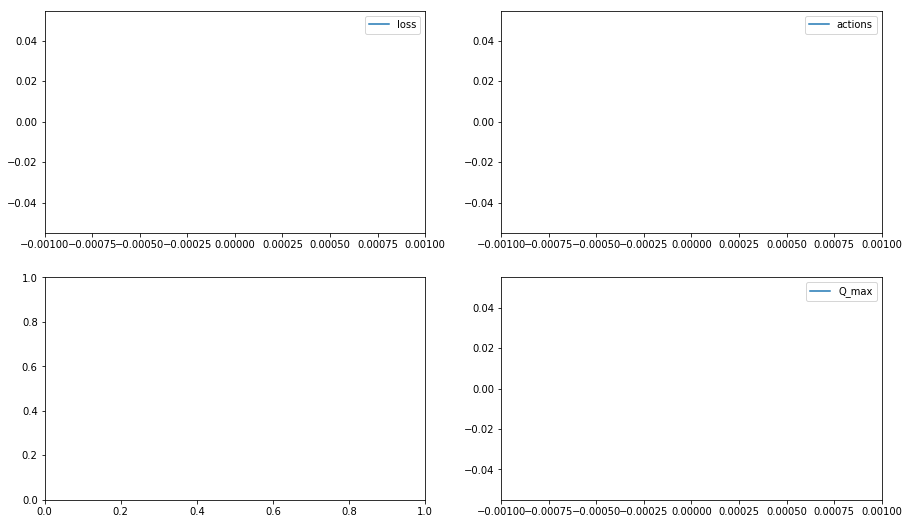

In [22]:
show_plots(realtime=False)